In [0]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda
!sudo ldconfig /usr/local/cuda/lib64
!pip install tensorflow-gpu==1.3
!pip install mxnet-cu80
!pip install pytesseract
!pip install gluonnlp
!pip install mxnet
!pip install leven
!pip install mxboard
import nltk
nltk.download('perluniprops')
nltk.download('nonbreaking_prefixes')
!pip install -U sacremoses
!sudo apt-get update
!sudo apt-get install enchant
!pip install pyenchant==1.6.8
!pip install sympound
!pip install weighted-levenshtein
!sudo apt-get install sox
!wget http://www.openslr.org/resources/4/sctk-2.4.10-20151007-1312Z.tar.bz2
!bzip2 -dk sctk-2.4.10-20151007-1312Z.tar.bz2
!tar -xvf sctk-2.4.10-20151007-1312Z.tar
!ls sctk-2.4.10
%cd sctk-2.4.10
!make config
!make all
!make check
!make install
!make doc
%cd bin
!./sclite
%cd ..
%cd ..
!ls

--2019-11-05 18:17:42--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.182.215
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.182.215|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?2ykho7fjo8jR4LFL0PFnHN2g4S3w9oPY54rre7XVHTwETLLf5TXd9uQXxAfUWD3WWho_7HA4lcD0GIOSgTspF_iyNRCxlQ6sFzmG4Ddc-h_0Zw7ayFha2-4mnz4d93KVN2ho4FTskYuOMDtkHH5bUQSEeKGBbTAFRg3kaof_L9D7pMVcjYPHrDV5SXlCshSK8GAlzugqrzpoxey5nzQ [following]
--2019-11-05 18:17:43--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?2ykho7fjo8jR4LFL0PFnHN2g4S3w9oPY54rre7XVHTwETLLf5TXd9uQXxAfUWD3WWho_7HA4lcD0GIOSgTspF_iyNRCxlQ6sFzmG4Ddc-h_0Zw7ayFha2-

In [0]:
# From https://github.com/githubharald/CTCDecoder
#
#MIT License

#Copyright (c) 2018 Harald Scheidl

#Permission is hereby granted, free of charge, to any person obtaining a copy
#of this software and associated documentation files (the "Software"), to deal
#in the Software without restriction, including without limitation the rights
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
#copies of the Software, and to permit persons to whom the Software is
#furnished to do so, subject to the following conditions:

#The above copyright notice and this permission notice shall be included in all
#copies or substantial portions of the Software.

#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
#IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
#FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
#AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
#LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
#OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
#SOFTWARE.

from __future__ import division
from __future__ import print_function
import numpy as np

class BeamEntry:
    "information about one single beam at specific time-step"
    def __init__(self):
        self.prTotal = 0 # blank and non-blank
        self.prNonBlank = 0 # non-blank
        self.prBlank = 0 # blank
        self.prText = 1 # LM score
        self.lmApplied = False # flag if LM was already applied to this beam
        self.labeling = () # beam-labeling

class BeamState:
    "information about the beams at specific time-step"
    def __init__(self):
        self.entries = {}
        
    def norm(self):
        "length-normalise LM score"
        for (k, _) in self.entries.items():
            labelingLen = len(self.entries[k].labeling)
            self.entries[k].prText = self.entries[k].prText ** (1.0 / (labelingLen if labelingLen else 1.0))

    def sort(self):
        "return beam-labelings, sorted by probability"
        beams = [v for (_, v) in self.entries.items()]
        sortedBeams = sorted(beams, reverse=True, key=lambda x: x.prTotal*x.prText)
        return [x.labeling for x in sortedBeams]

def applyLM(parentBeam, childBeam, classes, lm):
    "calculate LM score of child beam by taking score from parent beam and bigram probability of last two chars"
    if lm and not childBeam.lmApplied:
        c1 = classes[parentBeam.labeling[-1] if parentBeam.labeling else classes.index(' ')] # first char
        c2 = classes[childBeam.labeling[-1]] # second char
        lmFactor = 0.01 # influence of language model
        bigramProb = lm.getCharBigram(c1, c2) ** lmFactor # probability of seeing first and second char next to each other
        childBeam.prText = parentBeam.prText * bigramProb # probability of char sequence
        childBeam.lmApplied = True # only apply LM once per beam entry

def addBeam(beamState, labeling):
    "add beam if it does not yet exist"
    if labeling not in beamState.entries:
        beamState.entries[labeling] = BeamEntry()

def ctcBeamSearch(mat, classes, lm, beamWidth):
    "beam search as described by the paper of Hwang et al. and the paper of Graves et al."

    blankIdx = len(classes)
    maxT, maxC = mat.shape

    # initialise beam state
    last = BeamState()
    labeling = ()
    last.entries[labeling] = BeamEntry()
    last.entries[labeling].prBlank = 1
    last.entries[labeling].prTotal = 1

    # go over all time-steps
    for t in range(maxT):
        curr = BeamState()

        # get beam-labelings of best beams
        bestLabelings = last.sort()[0:beamWidth]

	# go over best beams
        for labeling in bestLabelings:

	    # probability of paths ending with a non-blank
            prNonBlank = 0
	    # in case of non-empty beam
            if labeling:
		# probability of paths with repeated last char at the end
                try: 
                    prNonBlank = last.entries[labeling].prNonBlank * mat[t, labeling[-1]]
                except FloatingPointError:
                    prNonBlank = 0

	    # probability of paths ending with a blank
            prBlank = (last.entries[labeling].prTotal) * mat[t, blankIdx]

	    # add beam at current time-step if needed
            addBeam(curr, labeling)

            # fill in data
            curr.entries[labeling].labeling = labeling
            curr.entries[labeling].prNonBlank += prNonBlank
            curr.entries[labeling].prBlank += prBlank
            curr.entries[labeling].prTotal += prBlank + prNonBlank
            curr.entries[labeling].prText = last.entries[labeling].prText # beam-labeling not changed, therefore also LM score unchanged from
            curr.entries[labeling].lmApplied = True # LM already applied at previous time-step for this beam-labeling

            # extend current beam-labeling
            for c in range(maxC - 1):
                # add new char to current beam-labeling
                newLabeling = labeling + (c,)

                # if new labeling contains duplicate char at the end, only consider paths ending with a blank
                if labeling and labeling[-1] == c:
                    prNonBlank = mat[t, c] * last.entries[labeling].prBlank
                else:
                    prNonBlank = mat[t, c] * last.entries[labeling].prTotal

		# add beam at current time-step if needed
                addBeam(curr, newLabeling)
				
		# fill in data
                curr.entries[newLabeling].labeling = newLabeling
                curr.entries[newLabeling].prNonBlank += prNonBlank
                curr.entries[newLabeling].prTotal += prNonBlank
				
		# apply LM
                applyLM(curr.entries[labeling], curr.entries[newLabeling], classes, lm)

        # set new beam state
        last = curr

    # normalise LM scores according to beam-labeling-length
    last.norm()

    # sort by probability
    bestLabelings = last.sort()[:beamWidth] # get most probable labeling

    output = []
    for bestLabeling in bestLabelings:
        # map labels to chars
        res = ''
        for l in bestLabeling:
            res += classes[l]
        output.append(res)
    return output

def testBeamSearch():
    "test decoder"
    classes = 'ab'
    mat = np.array([[0.4, 0, 0.6], [0.4, 0, 0.6]])
    print('Test beam search')
    expected = 'a'
    actual = ctcBeamSearch(mat, classes, None)
    print('Expected: "' + expected + '"')
    print('Actual: "' + actual + '"')
    print('OK' if expected == actual else 'ERROR')

#if __name__ == '__main__':
#  testBeamSearch()

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

"""Encoder and decoder usded in sequence-to-sequence learning."""
__all__ = ['TransformerEncoder', 'TransformerDecoder',
           'get_transformer_encoder_decoder']

from functools import partial
import math
import os
import string
import warnings



from gluonnlp.model import AttentionCell, MLPAttentionCell, DotProductAttentionCell, MultiHeadAttentionCell
import gluonnlp as nlp
import mxnet as mx
from mxnet.gluon import rnn
from mxnet.gluon.block import Block
from mxnet import cpu, gluon
from mxnet.gluon import nn
from mxnet.gluon.block import HybridBlock
from mxnet.gluon.loss import SoftmaxCELoss
import numpy as np


ALPHABET = ['<UNK>', '<PAD>', '<BOS>', '<EOS>']+list(' ' + string.ascii_letters + string.digits + string.punctuation)
ALPHABET_INDEX = {letter: index for index, letter in enumerate(ALPHABET)} # { a: 0, b: 1, etc}
EOS = 3
BOS = 2
PAD = 1
UNK = 0

def decode_char(text):
    output = []
    for val in text:
        if val == EOS:
            break
        elif val == PAD or val == BOS:
            continue
        output.append(ALPHABET[int(val)])
    return "".join(output)

def encode_char(text, src=True, max_len=150):
    encoded = np.ones(max_len, dtype='float32') * PAD
    text = text[:max_len-2]
    i = 0
    if not src:
        encoded[0] = BOS
        i = 1
    for letter in text:
        if letter in ALPHABET_INDEX:
            encoded[i] = ALPHABET_INDEX[letter]
        i += 1
    encoded[i] = EOS
    return encoded, np.array([i+1]).astype('float32')


def _list_bcast_where(F, mask, new_val_l, old_val_l):
    """Broadcast where. Implements out[i] = new_val[i] * mask + old_val[i] * (1 - mask)
    Parameters
    ----------
    F : symbol or ndarray
    mask : Symbol or NDArray
    new_val_l : list of Symbols or list of NDArrays
    old_val_l : list of Symbols or list of NDArrays
    Returns
    -------
    out_l : list of Symbols or list of NDArrays
    """
    return [F.broadcast_mul(new_val, mask) + F.broadcast_mul(old_val, 1 - mask)
            for new_val, old_val in zip(new_val_l, old_val_l)]


def _get_cell_type(cell_type):
    """Get the object type of the cell by parsing the input
    Parameters
    ----------
    cell_type : str or type
    Returns
    -------
    cell_constructor: type
        The constructor of the RNNCell
    """
    if isinstance(cell_type, str):
        if cell_type == 'lstm':
            return rnn.LSTMCell
        elif cell_type == 'gru':
            return rnn.GRUCell
        elif cell_type == 'relu_rnn':
            return partial(rnn.RNNCell, activation='relu')
        elif cell_type == 'tanh_rnn':
            return partial(rnn.RNNCell, activation='tanh')
        else:
            raise NotImplementedError
    else:
        return cell_type


def _get_attention_cell(attention_cell, units=None,
                        scaled=True, num_heads=None,
                        use_bias=False, dropout=0.0):
    """
    Parameters
    ----------
    attention_cell : AttentionCell or str
    units : int or None
    Returns
    -------
    attention_cell : AttentionCell
    """
    if isinstance(attention_cell, str):
        if attention_cell == 'scaled_luong':
            return DotProductAttentionCell(units=units, scaled=True, normalized=False,
                                           use_bias=use_bias, dropout=dropout, luong_style=True)
        elif attention_cell == 'scaled_dot':
            return DotProductAttentionCell(units=units, scaled=True, normalized=False,
                                           use_bias=use_bias, dropout=dropout, luong_style=False)
        elif attention_cell == 'dot':
            return DotProductAttentionCell(units=units, scaled=False, normalized=False,
                                           use_bias=use_bias, dropout=dropout, luong_style=False)
        elif attention_cell == 'cosine':
            return DotProductAttentionCell(units=units, scaled=False, use_bias=use_bias,
                                           dropout=dropout, normalized=True)
        elif attention_cell == 'mlp':
            return MLPAttentionCell(units=units, normalized=False)
        elif attention_cell == 'normed_mlp':
            return MLPAttentionCell(units=units, normalized=True)
        elif attention_cell == 'multi_head':
            base_cell = DotProductAttentionCell(scaled=scaled, dropout=dropout)
            return MultiHeadAttentionCell(base_cell=base_cell, query_units=units, use_bias=use_bias,
                                          key_units=units, value_units=units, num_heads=num_heads)
        else:
            raise NotImplementedError
    else:
        assert isinstance(attention_cell, AttentionCell),\
            'attention_cell must be either string or AttentionCell. Received attention_cell={}'\
                .format(attention_cell)
        return attention_cell


def _nested_sequence_last(data, valid_length):
    """
    Parameters
    ----------
    data : nested container of NDArrays/Symbols
        The input data. Each element will have shape (batch_size, ...)
    valid_length : NDArray or Symbol
        Valid length of the sequences. Shape (batch_size,)
    Returns
    -------
    data_last: nested container of NDArrays/Symbols
        The last valid element in the sequence.
    """
    assert isinstance(data, list)
    if isinstance(data[0], (mx.sym.Symbol, mx.nd.NDArray)):
        F = mx.sym if isinstance(data[0], mx.sym.Symbol) else mx.ndarray
        return F.SequenceLast(F.stack(*data, axis=0),
                              sequence_length=valid_length,
                              use_sequence_length=True)
    elif isinstance(data[0], list):
        ret = []
        for i in range(len(data[0])):
            ret.append(_nested_sequence_last([ele[i] for ele in data], valid_length))
        return ret
    else:
        raise NotImplementedError


class Seq2SeqEncoder(Block):
    r"""Base class of the encoders in sequence to sequence learning models.
    """
    def __call__(self, inputs, valid_length=None, states=None):  #pylint: disable=arguments-differ
        """Encode the input sequence.
        Parameters
        ----------
        inputs : NDArray
            The input sequence, Shape (batch_size, length, C_in).
        valid_length : NDArray or None, default None
            The valid length of the input sequence, Shape (batch_size,). This is used when the
            input sequences are padded. If set to None, all elements in the sequence are used.
        states : list of NDArrays or None, default None
            List that contains the initial states of the encoder.
        Returns
        -------
        outputs : list
            Outputs of the encoder.
        """
        return super(Seq2SeqEncoder, self).__call__(inputs, valid_length, states)

    def forward(self, inputs, valid_length=None, states=None):  #pylint: disable=arguments-differ
        raise NotImplementedError


class Seq2SeqDecoder(Block):
    r"""Base class of the decoders in sequence to sequence learning models.
    In the forward function, it generates the one-step-ahead decoding output.
    """
    def init_state_from_encoder(self, encoder_outputs, encoder_valid_length=None):
        r"""Generates the initial decoder states based on the encoder outputs.
        Parameters
        ----------
        encoder_outputs : list of NDArrays
        encoder_valid_length : NDArray or None
        Returns
        -------
        decoder_states : list
        """
        raise NotImplementedError

    def decode_seq(self, inputs, states, valid_length=None):
        r"""Given the inputs and the context computed by the encoder,
        generate the new states. This is usually used in the training phase where we set the inputs
        to be the target sequence.
        Parameters
        ----------
        inputs : NDArray
            The input embeddings. Shape (batch_size, length, C_in)
        states : list
            The initial states of the decoder.
        valid_length : NDArray or None
            valid length of the inputs. Shape (batch_size,)
        Returns
        -------
        output : NDArray
            The output of the decoder. Shape is (batch_size, length, C_out)
        states: list
            The new states of the decoder
        additional_outputs : list
            Additional outputs of the decoder, e.g, the attention weights
        """
        raise NotImplementedError

    def __call__(self, step_input, states):  #pylint: disable=arguments-differ
        r"""One-step decoding of the input
        Parameters
        ----------
        step_input : NDArray
            Shape (batch_size, C_in)
        states : list
            The previous states of the decoder
        Returns
        -------
        step_output : NDArray
            Shape (batch_size, C_out)
        states : list
        step_additional_outputs : list
            Additional outputs of the step, e.g, the attention weights
        """
        return super(Seq2SeqDecoder, self).__call__(step_input, states)

    def forward(self, step_input, states):  #pylint: disable=arguments-differ
        raise NotImplementedError
        
def _position_encoding_init(max_length, dim):
    """ Init the sinusoid position encoding table """
    position_enc = np.arange(max_length).reshape((-1, 1)) \
                   / (np.power(10000, (2. / dim) * np.arange(dim).reshape((1, -1))))
    # Apply the cosine to even columns and sin to odds.
    position_enc[:, 0::2] = np.sin(position_enc[:, 0::2])  # dim 2i
    position_enc[:, 1::2] = np.cos(position_enc[:, 1::2])  # dim 2i+1
    return position_enc


class PositionwiseFFN(HybridBlock):
    """Structure of the Positionwise Feed-Forward Neural Network.
    Parameters
    ----------
    units : int
    hidden_size : int
        number of units in the hidden layer of position-wise feed-forward networks
    dropout : float
    use_residual : bool
    weight_initializer : str or Initializer
        Initializer for the input weights matrix, used for the linear
        transformation of the inputs.
    bias_initializer : str or Initializer
        Initializer for the bias vector.
    activation : str, default 'relu'
        Activation function
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, units=512, hidden_size=2048, dropout=0.0, use_residual=True,
                 weight_initializer=None, bias_initializer='zeros', activation='relu',
                 prefix=None, params=None):
        super(PositionwiseFFN, self).__init__(prefix=prefix, params=params)
        self._hidden_size = hidden_size
        self._units = units
        self._use_residual = use_residual
        with self.name_scope():
            self.ffn_1 = nn.Dense(units=hidden_size, flatten=False,
                                  activation=activation,
                                  weight_initializer=weight_initializer,
                                  bias_initializer=bias_initializer,
                                  prefix='ffn_1_')
            self.ffn_2 = nn.Dense(units=units, flatten=False,
                                  weight_initializer=weight_initializer,
                                  bias_initializer=bias_initializer,
                                  prefix='ffn_2_')
            self.dropout_layer = nn.Dropout(dropout)
            self.layer_norm = nn.LayerNorm()

    def hybrid_forward(self, F, inputs):  # pylint: disable=arguments-differ
        # pylint: disable=unused-argument
        """Position-wise encoding of the inputs.
        Parameters
        ----------
        inputs : Symbol or NDArray
            Input sequence. Shape (batch_size, length, C_in)
        Returns
        -------
        outputs : Symbol or NDArray
            Shape (batch_size, length, C_out)
        """
        outputs = self.ffn_1(inputs)
        outputs = self.ffn_2(outputs)
        outputs = self.dropout_layer(outputs)
        if self._use_residual:
            outputs = outputs + inputs
        outputs = self.layer_norm(outputs)
        return outputs


class TransformerEncoderCell(HybridBlock):
    """Structure of the Transformer Encoder Cell.
    Parameters
    ----------
    attention_cell : AttentionCell or str, default 'multi_head'
        Arguments of the attention cell.
        Can be 'multi_head', 'scaled_luong', 'scaled_dot', 'dot', 'cosine', 'normed_mlp', 'mlp'
    units : int
    hidden_size : int
        number of units in the hidden layer of position-wise feed-forward networks
    num_heads : int
        Number of heads in multi-head attention
    scaled : bool
        Whether to scale the softmax input by the sqrt of the input dimension
        in multi-head attention
    dropout : float
    use_residual : bool
    output_attention: bool
        Whether to output the attention weights
    weight_initializer : str or Initializer
        Initializer for the input weights matrix, used for the linear
        transformation of the inputs.
    bias_initializer : str or Initializer
        Initializer for the bias vector.
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, attention_cell='multi_head', units=128,
                 hidden_size=512, num_heads=4, scaled=True,
                 dropout=0.0, use_residual=True, output_attention=False,
                 weight_initializer=None, bias_initializer='zeros',
                 prefix=None, params=None):
        super(TransformerEncoderCell, self).__init__(prefix=prefix, params=params)
        self._units = units
        self._num_heads = num_heads
        self._dropout = dropout
        self._use_residual = use_residual
        self._output_attention = output_attention
        with self.name_scope():
            self.dropout_layer = nn.Dropout(dropout)
            self.attention_cell = _get_attention_cell(attention_cell,
                                                      units=units,
                                                      num_heads=num_heads,
                                                      scaled=scaled,
                                                      dropout=dropout)
            self.proj = nn.Dense(units=units, flatten=False, use_bias=False,
                                 weight_initializer=weight_initializer,
                                 bias_initializer=bias_initializer,
                                 prefix='proj_')
            self.ffn = PositionwiseFFN(hidden_size=hidden_size, units=units,
                                       use_residual=use_residual, dropout=dropout,
                                       weight_initializer=weight_initializer,
                                       bias_initializer=bias_initializer)
            self.layer_norm = nn.LayerNorm()

    def hybrid_forward(self, F, inputs, mask=None):  # pylint: disable=arguments-differ
        # pylint: disable=unused-argument
        """Transformer Encoder Attention Cell.
        Parameters
        ----------
        inputs : Symbol or NDArray
            Input sequence. Shape (batch_size, length, C_in)
        mask : Symbol or NDArray or None
            Mask for inputs. Shape (batch_size, length, length)
        Returns
        -------
        encoder_cell_outputs: list
            Outputs of the encoder cell. Contains:
            - outputs of the transformer encoder cell. Shape (batch_size, length, C_out)
            - additional_outputs of all the transformer encoder cell
        """
        outputs, attention_weights =\
            self.attention_cell(inputs, inputs, inputs, mask)
        outputs = self.proj(outputs)
        outputs = self.dropout_layer(outputs)
        if self._use_residual:
            outputs = outputs + inputs
        outputs = self.layer_norm(outputs)
        outputs = self.ffn(outputs)
        additional_outputs = []
        if self._output_attention:
            additional_outputs.append(attention_weights)
        return outputs, additional_outputs


class TransformerDecoderCell(HybridBlock):
    """Structure of the Transformer Decoder Cell.
    Parameters
    ----------
    attention_cell : AttentionCell or str, default 'multi_head'
        Arguments of the attention cell.
        Can be 'multi_head', 'scaled_luong', 'scaled_dot', 'dot', 'cosine', 'normed_mlp', 'mlp'
    units : int
    hidden_size : int
        number of units in the hidden layer of position-wise feed-forward networks
    num_heads : int
        Number of heads in multi-head attention
    scaled : bool
        Whether to scale the softmax input by the sqrt of the input dimension
        in multi-head attention
    dropout : float
    use_residual : bool
    output_attention: bool
        Whether to output the attention weights
    weight_initializer : str or Initializer
        Initializer for the input weights matrix, used for the linear
        transformation of the inputs.
    bias_initializer : str or Initializer
        Initializer for the bias vector.
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, attention_cell='multi_head', units=128,
                 hidden_size=512, num_heads=4, scaled=True,
                 dropout=0.0, use_residual=True, output_attention=False,
                 weight_initializer=None, bias_initializer='zeros',
                 prefix=None, params=None):
        super(TransformerDecoderCell, self).__init__(prefix=prefix, params=params)
        self._units = units
        self._num_heads = num_heads
        self._dropout = dropout
        self._use_residual = use_residual
        self._output_attention = output_attention
        self._scaled = scaled
        with self.name_scope():
            self.dropout_layer = nn.Dropout(dropout)
            self.attention_cell_in = _get_attention_cell(attention_cell,
                                                         units=units,
                                                         num_heads=num_heads,
                                                         scaled=scaled,
                                                         dropout=dropout)
            self.attention_cell_inter = _get_attention_cell(attention_cell,
                                                            units=units,
                                                            num_heads=num_heads,
                                                            scaled=scaled,
                                                            dropout=dropout)
            self.proj_in = nn.Dense(units=units, flatten=False,
                                    use_bias=False,
                                    weight_initializer=weight_initializer,
                                    bias_initializer=bias_initializer,
                                    prefix='proj_in_')
            self.proj_inter = nn.Dense(units=units, flatten=False,
                                       use_bias=False,
                                       weight_initializer=weight_initializer,
                                       bias_initializer=bias_initializer,
                                       prefix='proj_inter_')
            self.ffn = PositionwiseFFN(hidden_size=hidden_size,
                                       units=units,
                                       use_residual=use_residual,
                                       dropout=dropout,
                                       weight_initializer=weight_initializer,
                                       bias_initializer=bias_initializer)

            self.layer_norm_in = nn.LayerNorm()
            self.layer_norm_inter = nn.LayerNorm()

    def hybrid_forward(self, F, inputs, mem_value, mask=None, mem_mask=None):  #pylint: disable=unused-argument
        #  pylint: disable=arguments-differ
        """Transformer Decoder Attention Cell.
        Parameters
        ----------
        inputs : Symbol or NDArray
            Input sequence. Shape (batch_size, length, C_in)
        mem_value : Symbol or NDArrays
            Memory value, i.e. output of the encoder. Shape (batch_size, mem_length, C_in)
        mask : Symbol or NDArray or None
            Mask for inputs. Shape (batch_size, length, length)
        mem_mask : Symbol or NDArray or None
            Mask for mem_value. Shape (batch_size, length, mem_length)
        Returns
        -------
        decoder_cell_outputs: list
            Outputs of the decoder cell. Contains:
            - outputs of the transformer decoder cell. Shape (batch_size, length, C_out)
            - additional_outputs of all the transformer decoder cell
        """
        outputs, attention_in_outputs =\
            self.attention_cell_in(inputs, inputs, inputs, mask)
        outputs = self.proj_in(outputs)
        outputs = self.dropout_layer(outputs)
        if self._use_residual:
            outputs = outputs + inputs
        outputs = self.layer_norm_in(outputs)
        inputs = outputs
        outputs, attention_inter_outputs = \
            self.attention_cell_inter(inputs, mem_value, mem_value, mem_mask)
        outputs = self.proj_inter(outputs)
        outputs = self.dropout_layer(outputs)
        if self._use_residual:
            outputs = outputs + inputs
        outputs = self.layer_norm_inter(outputs)
        outputs = self.ffn(outputs)
        additional_outputs = []
        if self._output_attention:
            additional_outputs.append(attention_in_outputs)
            additional_outputs.append(attention_inter_outputs)
        return outputs, additional_outputs


class TransformerEncoder(HybridBlock, Seq2SeqEncoder):
    """Structure of the Transformer Encoder.
    Parameters
    ----------
    attention_cell : AttentionCell or str, default 'multi_head'
        Arguments of the attention cell.
        Can be 'multi_head', 'scaled_luong', 'scaled_dot', 'dot', 'cosine', 'normed_mlp', 'mlp'
    num_layers : int
    units : int
    hidden_size : int
        number of units in the hidden layer of position-wise feed-forward networks
    max_length : int
        Maximum length of the input sequence
    num_heads : int
        Number of heads in multi-head attention
    scaled : bool
        Whether to scale the softmax input by the sqrt of the input dimension
        in multi-head attention
    dropout : float
    use_residual : bool
    output_attention: bool
        Whether to output the attention weights
    weight_initializer : str or Initializer
        Initializer for the input weights matrix, used for the linear
        transformation of the inputs.
    bias_initializer : str or Initializer
        Initializer for the bias vector.
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, attention_cell='multi_head', num_layers=2,
                 units=512, hidden_size=2048, max_length=50,
                 num_heads=4, scaled=True, dropout=0.0,
                 use_residual=True, output_attention=False,
                 weight_initializer=None, bias_initializer='zeros',
                 prefix=None, params=None):
        super(TransformerEncoder, self).__init__(prefix=prefix, params=params)
        assert units % num_heads == 0,\
            'In TransformerEncoder, The units should be divided exactly ' \
            'by the number of heads. Received units={}, num_heads={}' \
            .format(units, num_heads)
        self._num_layers = num_layers
        self._max_length = max_length
        self._num_heads = num_heads
        self._units = units
        self._hidden_size = hidden_size
        self._output_attention = output_attention
        self._dropout = dropout
        self._use_residual = use_residual
        self._scaled = scaled
        with self.name_scope():
            self.dropout_layer = nn.Dropout(dropout)
            self.layer_norm = nn.LayerNorm()
            self.position_weight = self.params.get_constant('const',
                                                            _position_encoding_init(max_length,
                                                                                    units))
            self.transformer_cells = nn.HybridSequential()
            for i in range(num_layers):
                self.transformer_cells.add(
                    TransformerEncoderCell(
                        units=units,
                        hidden_size=hidden_size,
                        num_heads=num_heads,
                        attention_cell=attention_cell,
                        weight_initializer=weight_initializer,
                        bias_initializer=bias_initializer,
                        dropout=dropout,
                        use_residual=use_residual,
                        scaled=scaled,
                        output_attention=output_attention,
                        prefix='transformer%d_' % i))

    def __call__(self, inputs, states=None, valid_length=None): #pylint: disable=arguments-differ
        """Encoder the inputs given the states and valid sequence length.
        Parameters
        ----------
        inputs : NDArray
            Input sequence. Shape (batch_size, length, C_in)
        states : list of NDArrays or None
            Initial states. The list of initial states and masks
        valid_length : NDArray or None
            Valid lengths of each sequence. This is usually used when part of sequence has
            been padded. Shape (batch_size,)
        Returns
        -------
        encoder_outputs: list
            Outputs of the encoder. Contains:
            - outputs of the transformer encoder. Shape (batch_size, length, C_out)
            - additional_outputs of all the transformer encoder
        """
        return super(TransformerEncoder, self).__call__(inputs, states, valid_length)

    def forward(self, inputs, states=None, valid_length=None, steps=None): # pylint: disable=arguments-differ
        """
        Parameters
        ----------
        inputs : NDArray, Shape(batch_size, length, C_in)
        states : list of NDArray
        valid_length : NDArray
        steps : NDArray
            Stores value [0, 1, ..., length].
            It is used for lookup in positional encoding matrix
        Returns
        -------
        outputs : NDArray
            The output of the encoder. Shape is (batch_size, length, C_out)
        additional_outputs : list
            Either be an empty list or contains the attention weights in this step.
            The attention weights will have shape (batch_size, length, length) or
            (batch_size, num_heads, length, length)
        """
        length = inputs.shape[1]
        if valid_length is not None:
            mask = mx.nd.broadcast_lesser(
                mx.nd.arange(length, ctx=valid_length.context).reshape((1, -1)),
                valid_length.reshape((-1, 1)))
            mask = mx.nd.broadcast_axes(mx.nd.expand_dims(mask, axis=1), axis=1, size=length)
            if states is None:
                states = [mask]
            else:
                states.append(mask)
        inputs = inputs * math.sqrt(inputs.shape[-1])
        steps = mx.nd.arange(length, ctx=inputs.context)
        if states is None:
            states = [steps]
        else:
            states.append(steps)
        if valid_length is not None:
            step_output, additional_outputs =\
                super(TransformerEncoder, self).forward(inputs, states, valid_length)
        else:
            step_output, additional_outputs =\
                super(TransformerEncoder, self).forward(inputs, states)
        return step_output, additional_outputs

    def hybrid_forward(self, F, inputs, states=None, valid_length=None, position_weight=None): # pylint: disable=arguments-differ
        """
        Parameters
        ----------
        inputs : NDArray or Symbol, Shape(batch_size, length, C_in)
        states : list of NDArray or Symbol
        valid_length : NDArray or Symbol
        position_weight : NDArray or Symbol
        Returns
        -------
        outputs : NDArray or Symbol
            The output of the encoder. Shape is (batch_size, length, C_out)
        additional_outputs : list
            Either be an empty list or contains the attention weights in this step.
            The attention weights will have shape (batch_size, length, length) or
            (batch_size, num_heads, length, length)
        """
        if states is not None:
            steps = states[-1]
            # Positional Encoding
            inputs = F.broadcast_add(inputs, F.expand_dims(F.Embedding(steps, position_weight,
                                                                       self._max_length,
                                                                       self._units), axis=0))
        inputs = self.dropout_layer(inputs)
        inputs = self.layer_norm(inputs)
        outputs = inputs
        if valid_length is not None:
            mask = states[-2]
        else:
            mask = None
        additional_outputs = []
        for cell in self.transformer_cells:
            outputs, attention_weights = cell(inputs, mask)
            inputs = outputs
            if self._output_attention:
                additional_outputs.append(attention_weights)
        if valid_length is not None:
            outputs = F.SequenceMask(outputs, sequence_length=valid_length,
                                     use_sequence_length=True, axis=1)
        return outputs, additional_outputs


class TransformerDecoder(HybridBlock, Seq2SeqDecoder):
    """Structure of the Transformer Decoder.
    Parameters
    ----------
    attention_cell : AttentionCell or str, default 'multi_head'
        Arguments of the attention cell.
        Can be 'multi_head', 'scaled_luong', 'scaled_dot', 'dot', 'cosine', 'normed_mlp', 'mlp'
    num_layers : int
    units : int
    hidden_size : int
        number of units in the hidden layer of position-wise feed-forward networks
    max_length : int
        Maximum length of the input sequence. This is used for constructing position encoding
    num_heads : int
        Number of heads in multi-head attention
    scaled : bool
        Whether to scale the softmax input by the sqrt of the input dimension
        in multi-head attention
    dropout : float
    use_residual : bool
    output_attention: bool
        Whether to output the attention weights
    weight_initializer : str or Initializer
        Initializer for the input weights matrix, used for the linear
        transformation of the inputs.
    bias_initializer : str or Initializer
        Initializer for the bias vector.
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, attention_cell='multi_head', num_layers=2,
                 units=128, hidden_size=2048, max_length=50,
                 num_heads=4, scaled=True, dropout=0.0,
                 use_residual=True, output_attention=False,
                 weight_initializer=None, bias_initializer='zeros',
                 prefix=None, params=None):
        super(TransformerDecoder, self).__init__(prefix=prefix, params=params)
        assert units % num_heads == 0, 'In TransformerDecoder, the units should be divided ' \
                                       'exactly by the number of heads. Received units={}, ' \
                                       'num_heads={}'.format(units, num_heads)
        self._num_layers = num_layers
        self._units = units
        self._hidden_size = hidden_size
        self._num_states = num_heads
        self._max_length = max_length
        self._dropout = dropout
        self._use_residual = use_residual
        self._output_attention = output_attention
        self._scaled = scaled
        with self.name_scope():
            self.dropout_layer = nn.Dropout(dropout)
            self.layer_norm = nn.LayerNorm()
            self.position_weight = self.params.get_constant('const',
                                                            _position_encoding_init(max_length,
                                                                                    units))
            self.transformer_cells = nn.HybridSequential()
            for i in range(num_layers):
                self.transformer_cells.add(
                    TransformerDecoderCell(
                        units=units,
                        hidden_size=hidden_size,
                        num_heads=num_heads,
                        attention_cell=attention_cell,
                        weight_initializer=weight_initializer,
                        bias_initializer=bias_initializer,
                        dropout=dropout,
                        scaled=scaled,
                        use_residual=use_residual,
                        output_attention=output_attention,
                        prefix='transformer%d_' % i))

    def init_state_from_encoder(self, encoder_outputs, encoder_valid_length=None):
        """Initialize the state from the encoder outputs.
        Parameters
        ----------
        encoder_outputs : list
        encoder_valid_length : NDArray or None
        Returns
        -------
        decoder_states : list
            The decoder states, includes:
            - mem_value : NDArray
            - mem_masks : NDArray, optional
        """
        mem_value = encoder_outputs
        decoder_states = [mem_value]
        mem_length = mem_value.shape[1]
        if encoder_valid_length is not None:
            mem_masks = mx.nd.broadcast_lesser(
                mx.nd.arange(mem_length, ctx=encoder_valid_length.context).reshape((1, -1)),
                encoder_valid_length.reshape((-1, 1)))
            decoder_states.append(mem_masks)
        self._encoder_valid_length = encoder_valid_length
        return decoder_states

    def decode_seq(self, inputs, states, valid_length=None):
        """Decode the decoder inputs. This function is only used for training.
        Parameters
        ----------
        inputs : NDArray, Shape (batch_size, length, C_in)
        states : list of NDArrays or None
            Initial states. The list of decoder states
        valid_length : NDArray or None
            Valid lengths of each sequence. This is usually used when part of sequence has
            been padded. Shape (batch_size,)
        Returns
        -------
        output : NDArray, Shape (batch_size, length, C_out)
        states : list
            The decoder states, includes:
            - mem_value : NDArray
            - mem_masks : NDArray, optional
        additional_outputs : list of list
            Either be an empty list or contains the attention weights in this step.
            The attention weights will have shape (batch_size, length, mem_length) or
            (batch_size, num_heads, length, mem_length)
        """
        batch_size = inputs.shape[0]
        length = inputs.shape[1]
        length_array = mx.nd.arange(length, ctx=inputs.context)
        mask = mx.nd.broadcast_lesser_equal(
            length_array.reshape((1, -1)),
            length_array.reshape((-1, 1)))
        if valid_length is not None:
            batch_mask = mx.nd.broadcast_lesser(
                mx.nd.arange(length, ctx=valid_length.context).reshape((1, -1)),
                valid_length.reshape((-1, 1)))
            mask = mx.nd.broadcast_mul(mx.nd.expand_dims(batch_mask, -1),
                                       mx.nd.expand_dims(mask, 0))
        else:
            mask = mx.nd.broadcast_axes(mx.nd.expand_dims(mask, axis=0), axis=0, size=batch_size)
        states = [None] + states
        output, states, additional_outputs = self.forward(inputs, states, mask)
        states = states[1:]
        if valid_length is not None:
            output = mx.nd.SequenceMask(output,
                                        sequence_length=valid_length,
                                        use_sequence_length=True,
                                        axis=1)
        return output, states, additional_outputs

    def __call__(self, step_input, states): #pylint: disable=arguments-differ
        """One-step-ahead decoding of the Transformer decoder.
        Parameters
        ----------
        step_input : NDArray
        states : list of NDArray
        Returns
        -------
        step_output : NDArray
            The output of the decoder.
            In the train mode, Shape is (batch_size, length, C_out)
            In the test mode, Shape is (batch_size, C_out)
        new_states: list
            Includes
            - last_embeds : NDArray or None
                It is only given during testing
            - mem_value : NDArray
            - mem_masks : NDArray, optional
        step_additional_outputs : list of list
            Either be an empty list or contains the attention weights in this step.
            The attention weights will have shape (batch_size, length, mem_length) or
            (batch_size, num_heads, length, mem_length)
        """
        return super(TransformerDecoder, self).__call__(step_input, states)

    def forward(self, step_input, states, mask=None):  #pylint: disable=arguments-differ, missing-docstring
        input_shape = step_input.shape
        mem_mask = None
        # If it is in testing, transform input tensor to a tensor with shape NTC
        # Otherwise remove the None in states.
        if len(input_shape) == 2:
            if self._encoder_valid_length is not None:
                has_last_embeds = len(states) == 3
            else:
                has_last_embeds = len(states) == 2
            if has_last_embeds:
                last_embeds = states[0]
                step_input = mx.nd.concat(last_embeds,
                                          mx.nd.expand_dims(step_input, axis=1),
                                          dim=1)
                states = states[1:]
            else:
                step_input = mx.nd.expand_dims(step_input, axis=1)
        elif states[0] is None:
            states = states[1:]
        has_mem_mask = (len(states) == 2)
        if has_mem_mask:
            _, mem_mask = states
            augmented_mem_mask = mx.nd.expand_dims(mem_mask, axis=1)\
                .broadcast_axes(axis=1, size=step_input.shape[1])
            states[-1] = augmented_mem_mask
        if mask is None:
            length_array = mx.nd.arange(step_input.shape[1], ctx=step_input.context)
            mask = mx.nd.broadcast_lesser_equal(
                length_array.reshape((1, -1)),
                length_array.reshape((-1, 1)))
            mask = mx.nd.broadcast_axes(mx.nd.expand_dims(mask, axis=0),
                                        axis=0, size=step_input.shape[0])
        steps = mx.nd.arange(step_input.shape[1], ctx=step_input.context)
        states.append(steps)
        step_output, step_additional_outputs = \
            super(TransformerDecoder, self).forward(step_input * math.sqrt(step_input.shape[-1]),  #pylint: disable=too-many-function-args
                                                    states, mask)
        states = states[:-1]
        if has_mem_mask:
            states[-1] = mem_mask
        new_states = [step_input] + states
        # If it is in testing, only output the last one
        if len(input_shape) == 2:
            step_output = step_output[:, -1, :]
        return step_output, new_states, step_additional_outputs

    def hybrid_forward(self, F, step_input, states, mask=None, position_weight=None):  #pylint: disable=arguments-differ
        """
        Parameters
        ----------
        step_input : NDArray or Symbol, Shape (batch_size, length, C_in)
        states : list of NDArray or Symbol
        mask : NDArray or Symbol
        position_weight : NDArray or Symbol
        Returns
        -------
        step_output : NDArray or Symbol
            The output of the decoder. Shape is (batch_size, length, C_out)
        step_additional_outputs : list
            Either be an empty list or contains the attention weights in this step.
            The attention weights will have shape (batch_size, length, mem_length) or
            (batch_size, num_heads, length, mem_length)
        """
        has_mem_mask = (len(states) == 3)
        if has_mem_mask:
            mem_value, mem_mask, steps = states
        else:
            mem_value, steps = states
            mem_mask = None
        # Positional Encoding
        step_input = F.broadcast_add(step_input,
                                     F.expand_dims(F.Embedding(steps,
                                                               position_weight,
                                                               self._max_length,
                                                               self._units),
                                                   axis=0))
        step_input = self.dropout_layer(step_input)
        step_input = self.layer_norm(step_input)
        inputs = step_input
        outputs = inputs
        step_additional_outputs = []
        attention_weights_l = []
        for cell in self.transformer_cells:
            outputs, attention_weights = cell(inputs, mem_value, mask, mem_mask)
            if self._output_attention:
                attention_weights_l.append(attention_weights)
            inputs = outputs
        if self._output_attention:
            step_additional_outputs.extend(attention_weights_l)
        return outputs, step_additional_outputs


def get_transformer_encoder_decoder(num_layers=2,
                                    num_heads=8, scaled=True,
                                    units=512, hidden_size=2048, dropout=0.0, use_residual=True,
                                    max_src_length=50, max_tgt_length=50,
                                    weight_initializer=None, bias_initializer='zeros',
                                    prefix='transformer_', params=None):
    """Build a pair of Parallel GNMT encoder/decoder
    Parameters
    ----------
    num_layers : int
    num_heads : int
    scaled : bool
    units : int
    hidden_size : int
    dropout : float
    use_residual : bool
    max_src_length : int
    max_tgt_length : int
    weight_initializer : mx.init.Initializer or None
    bias_initializer : mx.init.Initializer or None
    prefix : str, default 'transformer_'
        Prefix for name of `Block`s.
    params : Parameter or None
        Container for weight sharing between layers.
        Created if `None`.
    Returns
    -------
    encoder : TransformerEncoder
    decoder :TransformerDecoder
    """
    encoder = TransformerEncoder(num_layers=num_layers,
                                 num_heads=num_heads,
                                 max_length=max_src_length,
                                 units=units,
                                 hidden_size=hidden_size,
                                 dropout=dropout,
                                 scaled=scaled,
                                 use_residual=use_residual,
                                 weight_initializer=weight_initializer,
                                 bias_initializer=bias_initializer,
                                 prefix=prefix + 'enc_', params=params)
    decoder = TransformerDecoder(num_layers=num_layers,
                                 num_heads=num_heads,
                                 max_length=max_tgt_length,
                                 units=units,
                                 hidden_size=hidden_size,
                                 dropout=dropout,
                                 scaled=scaled,
                                 use_residual=use_residual,
                                 weight_initializer=weight_initializer,
                                 bias_initializer=bias_initializer,
                                 prefix=prefix + 'dec_', params=params)
    return encoder, decoder

class Denoiser(gluon.nn.HybridBlock):
    def __init__(self, alphabet_size, embed_size=128, max_src_length=150, max_tgt_length=150, vocab=None, num_heads=8, num_layers=2, shared_embedding=False):
        super(Denoiser, self).__init__()
        encoder, decoder = get_transformer_encoder_decoder(max_src_length=max_src_length, max_tgt_length=max_tgt_length, units=embed_size, num_heads=num_heads, num_layers=num_layers)
        self.encoder = encoder
        self.decoder = decoder
        self.src_embedding = gluon.nn.HybridSequential()
        output_dim = alphabet_size
        with self.src_embedding.name_scope():
             self.src_embedding.add(gluon.nn.Embedding(input_dim=alphabet_size, output_dim=embed_size),
                                gluon.nn.Dropout(rate=0.5))
        
        
        if shared_embedding and vocab == None:
            self.tgt_embedding = self.src_embedding
        else:
            if vocab != None:
                input_dim, output_dim = vocab.embedding.idx_to_vec.shape
                embedding = gluon.nn.Embedding(input_dim, output_dim)
                embedding.initialize()
                embedding.weight.set_data(vocab.embedding.idx_to_vec)
            else:
                
                embedding = gluon.nn.Embedding(input_dim=alphabet_size, output_dim=embed_size)
                self.tgt_embedding = gluon.nn.HybridSequential()
                with self.tgt_embedding.name_scope():
                    self.tgt_embedding.add(embedding,
                                    gluon.nn.Dropout(rate=0.5))
        
        self.tgt_proj = gluon.nn.Dense(units=output_dim, flatten=False, #params=self.tgt_embedding[0].params,
                                 prefix='tgt_proj_')
        
    def hybrid_forward(self, F, src_seq, tgt_seq, src_valid_length, tgt_valid_length):
        encoder_outputs, encoder_additional_outputs = self.encode(src_seq, valid_length=src_valid_length)
        decoder_states = self.decoder.init_state_from_encoder(encoder_outputs, encoder_valid_length=src_valid_length)
        tgt_embed = self.tgt_embedding(tgt_seq)
        outputs, _, _ = self.decoder.decode_seq(tgt_embed, decoder_states, tgt_valid_length)
        outputs = self.tgt_proj(outputs)
        return outputs
    
    def encode(self, inputs, states=None, valid_length=None):
        return self.encoder(self.src_embedding(inputs), states, valid_length)
    
    def decode_step(self, step_input, states):
        step_output, states, step_additional_outputs = self.decoder(self.tgt_embedding(step_input), states)
        step_output = self.tgt_proj(step_output)
        return step_output, states, step_additional_outputs
    
    def decode_logprob(self, step_input, states):
        out, states, _ = self.decode_step(step_input, states)
        return out, states
    
    
class SoftmaxCEMaskedLoss(SoftmaxCELoss):
    """Wrapper of the SoftmaxCELoss that supports valid_length as the input
    """
    def hybrid_forward(self, F, pred, label, valid_length): # pylint: disable=arguments-differ
        """
        Parameters
        ----------
        F
        pred : Symbol or NDArray
            Shape (batch_size, length, V)
        label : Symbol or NDArray
            Shape (batch_size, length)
        valid_length : Symbol or NDArray
            Shape (batch_size, )
        Returns
        -------
        loss : Symbol or NDArray
            Shape (batch_size,)
        """
        if self._sparse_label:
            sample_weight = F.cast(F.expand_dims(F.ones_like(label), axis=-1), dtype=np.float32)
        else:
            sample_weight = F.ones_like(label)
        sample_weight = F.SequenceMask(sample_weight,
                                       sequence_length=valid_length,
                                       use_sequence_length=True,
                                       axis=1)
        return super(SoftmaxCEMaskedLoss, self).hybrid_forward(F, pred, label, sample_weight)

# pylint: disable=unused-argument
class _SmoothingWithDim(mx.operator.CustomOp):
    def __init__(self, epsilon=0.1, axis=-1):
        super(_SmoothingWithDim, self).__init__(True)
        self._epsilon = epsilon
        self._axis = axis

    def forward(self, is_train, req, in_data, out_data, aux):
        inputs = in_data[0]
        outputs = ((1 - self._epsilon) * inputs) + (self._epsilon / float(inputs.shape[self._axis]))
        self.assign(out_data[0], req[0], outputs)

    def backward(self, req, out_grad, in_data, out_data, in_grad, aux):
        self.assign(in_grad[0], req[0], (1 - self._epsilon) * out_grad[0])


@mx.operator.register('_smoothing_with_dim')
class _SmoothingWithDimProp(mx.operator.CustomOpProp):
    def __init__(self, epsilon=0.1, axis=-1):
        super(_SmoothingWithDimProp, self).__init__(True)
        self._epsilon = float(epsilon)
        self._axis = int(axis)

    def list_arguments(self):
        return ['data']

    def list_outputs(self):
        return ['output']

    def infer_shape(self, in_shape):
        data_shape = in_shape[0]
        output_shape = data_shape
        return (data_shape,), (output_shape,), ()

    def declare_backward_dependency(self, out_grad, in_data, out_data):
        return out_grad

    def create_operator(self, ctx, in_shapes, in_dtypes):
        #  create and return the CustomOp class.
        return _SmoothingWithDim(self._epsilon, self._axis)
# pylint: enable=unused-argument


class LabelSmoothing(HybridBlock):
    """Applies label smoothing. See https://arxiv.org/abs/1512.00567.
    Parameters
    ----------
    axis : int, default -1
        The axis to smooth.
    epsilon : float, default 0.1
        The epsilon parameter in label smoothing
    sparse_label : bool, default True
        Whether input is an integer array instead of one hot array.
    units : int or None
        Vocabulary size. If units is not given, it will be inferred from the input.
    prefix : str, default 'rnn_'
        Prefix for name of `Block`s
        (and name of weight if params is `None`).
    params : Parameter or None
        Container for weight sharing between cells.
        Created if `None`.
    """
    def __init__(self, axis=-1, epsilon=0.1, units=None,
                 sparse_label=True, prefix=None, params=None):
        super(LabelSmoothing, self).__init__(prefix=prefix, params=params)
        self._axis = axis
        self._epsilon = epsilon
        self._sparse_label = sparse_label
        self._units = units

    def hybrid_forward(self, F, inputs, units=None): # pylint: disable=arguments-differ
        """
        Parameters
        ----------
        F
        inputs : Symbol or NDArray
            Shape (batch_size, length) or (batch_size, length, V)
        units : int or None
        Returns
        -------
        smoothed_label : Symbol or NDArray
            Shape (batch_size, length, V)
        """
        if self._sparse_label:
            assert units is not None or self._units is not None, \
                'units needs to be given in function call or ' \
                'instance initialization when sparse_label is False'
            if units is None:
                units = self._units
            inputs = F.one_hot(inputs, depth=units)
        if units is None and self._units is None:
            return F.Custom(inputs, epsilon=self._epsilon, axis=self._axis,
                            op_type='_smoothing_with_dim')
        else:
            if units is None:
                units = self._units
            return ((1 - self._epsilon) * inputs) + (self._epsilon / units)

In [0]:
import gluonnlp as nlp
import leven
import mxnet as mx
import numpy as np


class SequenceGenerator:
    
    def __init__(self, sampler, language_model, vocab, ctx_nlp, tokenizer=nlp.data.SacreMosesTokenizer(), detokenizer=nlp.data.SacreMosesDetokenizer()):
        self.sampler = sampler
        self.language_model = language_model
        self.ctx_nlp = ctx_nlp
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.detokenizer = detokenizer

    def generate_sequences(self, inputs, begin_states, sentence):
        samples, scores, valid_lengths = self.sampler(inputs, begin_states)
        samples = samples[0].asnumpy()
        scores = scores[0].asnumpy()
        valid_lengths = valid_lengths[0].asnumpy()
        max_score = -10e20

        # Heuristic #1
        #If the sentence is correct, let's not try to change it 
        sentence_tokenized = [i.replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&") for i in self.tokenizer(sentence)]
        sentence_correct = True
        for token in sentence_tokenized:
            if (token not in self.vocab or self.vocab[token] > 400000) and token.lower() not in ["don't", "doesn't", "can't", "won't", "ain't", "couldn't", "i'd", "you'd", "he's", "she's", "it's", "i've", "you've", "she'd"]:
                sentence_correct = False
                break
        if sentence_correct:
            return sentence

        # Heuristic #2
        # We want sentence that have the most in-vocabulary words
        # and we penalize sentences that have out of vocabulary words 
        # that do not start with a capital letter
        for i, sample in enumerate(samples):
            tokens = decode_char(sample[:valid_lengths[i]])
            tokens = [i.replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&") for i in self.tokenizer(tokens)]
            score = 0

            for t in tokens:
                # Boosting names
                if (t in self.vocab and self.vocab[t] < 450000) or (len(t) > 0 and t.istitle()):
                    score += 0
                else:
                    score -= 1
                score -= 0
            if score == max_score:
                max_score = score
                best_tokens.append(tokens)
            elif score > max_score:
                max_score = score
                best_tokens = [tokens]

        # Heurisitic #3
        # Smallest edit distance
        # We then take the sentence with the lowest edit distance
        # From the predicted original sentence
        best_dist = 1000
        output_tokens = best_tokens[0]
        best_tokens_ = []
        for tokens in best_tokens:
            dist = leven.levenshtein(sentence, ' '.join(self.detokenizer(tokens)))
            if dist < best_dist:
                best_dist = dist
                best_tokens_ =[tokens]
            elif dist == best_dist:
                best_tokens_.append(tokens)

        # Heuristic #4
        # We take the sentence with the smallest number of tokens 
        # to avoid split up composed words
        min_len = 10e20
        for tokens in best_tokens_:
            if len(tokens) < min_len:
                min_len = len(tokens)
                best_tokens__ = [tokens]
            elif len(tokens) == min_len:
                best_tokens__.append(tokens)

        # Heuristic #5 
        # Lowest ppl
        # If we still have ties we take the sentence with the lowest
        # Perplexity score according to the language model
        best_ppl = 10e20            
        for tokens in best_tokens__:
            if len(tokens) > 1:
                inputs = self.vocab[tokens]
                hidden = self.language_model.begin_state(batch_size=1, func=mx.nd.zeros, ctx=self.ctx_nlp)
                output, _ = self.language_model(mx.nd.array(inputs).expand_dims(axis=1).as_in_context(self.ctx_nlp), hidden)
                output = output.softmax()
                l = 0
                for i in range(1, len(inputs)):
                    l += -output[i-1][0][inputs[i]].log()
                ppl = (l/len(inputs)).exp()
                if ppl < best_ppl:
                    output_tokens = tokens
                    best_ppl = ppl
        output = ' '.join(self.detokenizer(output_tokens))


        # Heuristic #6
        # Sometimes there are artefact at the end of the corrected sentence
        # We cut the end of the sentence
        if len(output) > len(sentence) + 10:
            output = output[:len(sentence)+2]
        return output

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
from skimage.draw import line_aa
import matplotlib.pyplot as plt

def draw_line(image, y1, x1, y2, x2, line_type):
    rr, cc, val = line_aa(y1, x1, y2, x2)
    if line_type == "dotted":
        rr = np.delete(rr, np.arange(0, rr.size, 5))
        cc = np.delete(cc, np.arange(0, cc.size, 5))
    image[rr, cc] = 0
    return image
    
def draw_box(bounding_box, image, line_type, is_xywh=True):
    image_h, image_w = image.shape[-2:]
    if is_xywh:
        (x, y, w, h) = bounding_box
        (x1, y1, x2, y2) = (x, y, x + w, y + h)
    else:
        (x1, y1, x2, y2) = bounding_box
    (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
    if y2 >= image_h:
        y2 = image_h - 1
    if x2 >= image_w:
        x2 = image_w - 1
    if y1 >= image_h:
        y1 = image_h - 1
    if x1 >= image_w:
        x1 = image_w - 1
    if y2 < 0:
        y2 = 0
    if x2 < 0:
        x2 =0
    if y1 < 0:
        y1 = 0
    if x1 < 0:
        x1 = 0

    image = draw_line(image, y1, x1, y2, x1, line_type)
    image = draw_line(image, y2, x1, y2, x2, line_type)
    image = draw_line(image, y2, x2, y1, x2, line_type)
    image = draw_line(image, y1, x2, y1, x1, line_type)
    return image

def draw_boxes_on_image(pred, label, images):
    ''' Function to draw multiple bounding boxes on the images. Predicted bounding boxes will be
    presented with a dotted line and actual boxes are presented with a solid line.
    Parameters
    ----------
    
    pred: [n x [x, y, w, h]]
        The predicted bounding boxes in percentages. 
        n is the number of bounding boxes predicted on an image
    label: [n x [x, y, w, h]]
        The actual bounding boxes in percentages
        n is the number of bounding boxes predicted on an image
    images: [[np.array]]
        The correponding images.
    Returns
    -------
    images: [[np.array]]
        Images with bounding boxes printed on them.
    '''
    image_h, image_w = images.shape[-2:]
    label[:, :, 0], label[:, :, 1] = label[:, :, 0] * image_w, label[:, :, 1] * image_h
    label[:, :, 2], label[:, :, 3] = label[:, :, 2] * image_w, label[:, :, 3] * image_h
    for i in range(len(pred)):
        pred_b = pred[i]
        pred_b[:, 0], pred_b[:, 1] = pred_b[:, 0] * image_w, pred_b[:, 1] * image_h
        pred_b[:, 2], pred_b[:, 3] = pred_b[:, 2] * image_w, pred_b[:, 3] * image_h

        image = images[i, 0]
        for j in range(pred_b.shape[0]):
            image = draw_box(pred_b[j, :], image, line_type="dotted")

        for k in range(label.shape[1]):
            image = draw_box(label[i, k, :], image, line_type="solid")
        images[i, 0, :, :] = image
    return images

def draw_box_on_image(pred, label, images):
    ''' Function to draw bounding boxes on the images. Predicted bounding boxes will be
    presented with a dotted line and actual boxes are presented with a solid line.
    Parameters
    ----------
    
    pred: [[x, y, w, h]]
        The predicted bounding boxes in percentages
    label: [[x, y, w, h]]
        The actual bounding boxes in percentages
    images: [[np.array]]
        The correponding images.
    Returns
    -------
    images: [[np.array]]
        Images with bounding boxes printed on them.
    '''

    image_h, image_w = images.shape[-2:]
    pred[:, 0], pred[:, 1] = pred[:, 0] * image_w, pred[:, 1] * image_h
    pred[:, 2], pred[:, 3] = pred[:, 2] * image_w, pred[:, 3] * image_h

    label[:, 0], label[:, 1] = label[:, 0] * image_w, label[:, 1] * image_h
    label[:, 2], label[:, 3] = label[:, 2] * image_w, label[:, 3] * image_h

    for i in range(images.shape[0]):
        image = images[i, 0]
        image = draw_box(pred[i, :], image, line_type="dotted")
        image = draw_box(label[i, :], image, line_type="solid")
        images[i, 0, :, :] = image
    return images

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import cv2
import numpy as np

def draw_text_on_image(images, text):
    output_image_shape = (images.shape[0], images.shape[1], images.shape[2] * 2, images.shape[3])  # Double the output_image_shape to print the text in the bottom
    
    output_images = np.zeros(shape=output_image_shape)
    for i in range(images.shape[0]):
        white_image_shape = (images.shape[2], images.shape[3])
        white_image = np.ones(shape=white_image_shape)*1.0
        text_image = cv2.putText(white_image, text[i], org=(5, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=0.0, thickness=1)
        output_images[i, :, :images.shape[2], :] = images[i]
        output_images[i, :, images.shape[2]:, :] = text_image
    return output_images

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

def expand_bounding_box(bb, expand_bb_scale_x=0.05, expand_bb_scale_y=0.05):
    (x, y, w, h) = bb
    new_w = (1 + expand_bb_scale_x) * w
    new_h = (1 + expand_bb_scale_y) * h
        
    x = x - (new_w - w)/2
    y = y - (new_h - h)/2
    w = new_w
    h = new_h
    return (x, y, w, h)

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import os
import tarfile
import urllib
import sys
import time
import glob
import pickle
import xml.etree.ElementTree as ET
import cv2
import json
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import logging

from mxnet.gluon.data import dataset
from mxnet import nd


def crop_image(image, bb):
    ''' Helper function to crop the image by the bounding box (in percentages)
    '''
    (x, y, w, h) = bb
    x = x * image.shape[1]
    y = y * image.shape[0]
    w = w * image.shape[1]
    h = h * image.shape[0]
    (x1, y1, x2, y2) = (x, y, x + w, y + h)
    (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
    return image[y1:y2, x1:x2]

def resize_image(image, desired_size):
    ''' Helper function to resize an image while keeping the aspect ratio.
    Parameter
    ---------
    
    image: np.array
        The image to be resized.
    desired_size: (int, int)
        The (height, width) of the resized image
    Return
    ------
    image: np.array
        The image of size = desired_size
    bounding box: (int, int, int, int)
        (x, y, w, h) in percentages of the resized image of the original
    '''
    size = image.shape[:2]
    if size[0] > desired_size[0] or size[1] > desired_size[1]:
        ratio_w = float(desired_size[0])/size[0]
        ratio_h = float(desired_size[1])/size[1]
        ratio = min(ratio_w, ratio_h)
        new_size = tuple([int(x*ratio) for x in size])
        image = cv2.resize(image, (new_size[1], new_size[0]))
        size = image.shape
            
    delta_w = max(0, desired_size[1] - size[1])
    delta_h = max(0, desired_size[0] - size[0])
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
            
    color = image[0][0]
    if color < 230:
        color = 230
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
    crop_bb = (left/image.shape[1], top/image.shape[0], (image.shape[1] - right - left)/image.shape[1],
               (image.shape[0] - bottom - top)/image.shape[0])
    image[image > 230] = 255
    return image, crop_bb

def crop_handwriting_page(image, bb, image_size):
    '''
    Given an image and bounding box (bb) crop the input image based on the bounding box.
    The final output image was scaled based on the image size.
    
    Parameters
    ----------
    image: np.array
        Input form image
    
    bb: (x, y, w, h)
        The bounding box in percentages to crop
        
    image_size: (h, w)
        Image size to scale the output image to.
        
    Returns
    -------
    output_image: np.array
        cropped image of size image_size.
    '''
    image = crop_image(image, bb)

    image, _ = resize_image(image, desired_size=image_size)
    return image

class IAMDataset(dataset.ArrayDataset):
    """ The IAMDataset provides images of handwritten passages written by multiple
    individuals. The data is available at http://www.fki.inf.unibe.ch
    The passages can be parsed into separate words, lines, or the whole form.
    The dataset should be separated into writer independent training and testing sets.
    Parameters
    ----------
    parse_method: str, Required
        To select the method of parsing the images of the passage
        Available options: [form, form_bb, line, word]
    credentials: (str, str), Default None 
        Your (username, password) for the IAM dataset. Register at
        http://www.fki.inf.unibe.ch/DBs/iamDB/iLogin/index.php
        By default, IAMDataset will read it from credentials.json
    
    root: str, default: dataset/iamdataset
        Location to save the database
    train: bool, default True
        Whether to load the training or testing set of writers.
    output_data_type: str, default text
        What type of data you want as an output: Text or bounding box.
        Available options are: [text, bb]
     
    output_parse_method: str, default None
        If the bounding box (bb) was selected as an output_data_type, 
        this parameter can select which bb you want to obtain.
        Available options: [form, line, word]
        
    output_form_text_as_array: bool, default False
        When output_data is set to text and the parse method is set to form or form_original,
        if output_form_text_as_array is true, the output text will be a list of lines string
    """
    MAX_IMAGE_SIZE_FORM = (1120, 800)
    MAX_IMAGE_SIZE_LINE = (60, 800)
    MAX_IMAGE_SIZE_WORD = (30, 140)
    def __init__(self, parse_method="line", credentials=("ishanguptads","29thoct"),
                 root=os.path.join('dataset', 'iamdataset'), 
                 train=True, output_data="text",
                 output_parse_method="line",
                 output_form_text_as_array=False):

        _parse_methods = ["form", "form_original", "form_bb", "line", "word"]
        error_message = "{} is not a possible parsing method: {}".format(
            parse_method, _parse_methods)
        assert parse_method in _parse_methods, error_message
        self._parse_method = parse_method
        url_partial = "http://www.fki.inf.unibe.ch/DBs/iamDB/data/{data_type}/{filename}.tgz"
        if self._parse_method == "form":
            self._data_urls = [url_partial.format(data_type="forms", filename="forms" + a) for a in ["A-D", "E-H", "I-Z"]]
        elif self._parse_method == "form_bb":
            self._data_urls = [url_partial.format(data_type="forms", filename="forms" + a) for a in ["A-D", "E-H", "I-Z"]]
        elif self._parse_method == "form_original":
            self._data_urls = [url_partial.format(data_type="forms", filename="forms" + a) for a in ["A-D", "E-H", "I-Z"]]
        elif self._parse_method == "line":
            self._data_urls = [url_partial.format(data_type="lines", filename="lines")]
        elif self._parse_method == "word":
            self._data_urls = [url_partial.format(data_type="words", filename="words")]
        self._xml_url = "http://www.fki.inf.unibe.ch/DBs/iamDB/data/xml/xml.tgz"

        #if credentials == None:
         #   if os.path.isfile(os.path.join(os.path.dirname(__file__), '..','..', 'credentials.json')):
         #       with open(os.path.join(os.path.dirname(__file__), '..','..', 'credentials.json')) as f:
         #           credentials = json.load(f)
         #       self._credentials = (credentials["username"], credentials["password"])
         #   else:
         #       assert False, "Please enter credentials for the IAM dataset in credentials.json or as arguments"
        #else:
        self._credentials = credentials
        
        self._train = train

        _output_data_types = ["text", "bb"]
        error_message = "{} is not a possible output data: {}".format(
            output_data, _output_data_types)
        assert output_data in _output_data_types, error_message
        self._output_data = output_data

        if self._output_data == "bb":
            assert self._parse_method in ["form", "form_bb"], "Bounding box only works with form."
            _parse_methods = ["form", "line", "word"]
            error_message = "{} is not a possible output parsing method: {}".format(
                output_parse_method, _parse_methods)
            assert output_parse_method in _parse_methods, error_message
            self._output_parse_method = output_parse_method

            self.image_data_file_name = os.path.join(root, "image_data-{}-{}-{}*.plk".format(
                self._parse_method, self._output_data, self._output_parse_method))
        else:
            self.image_data_file_name = os.path.join(root, "image_data-{}-{}*.plk".format(self._parse_method, self._output_data))

        self._root = root
        if not os.path.isdir(root):
            os.makedirs(root)
        self._output_form_text_as_array = output_form_text_as_array
        
        data = self._get_data()
        super(IAMDataset, self).__init__(data)

    @staticmethod
    def _reporthook(count, block_size, total_size):
        ''' Prints a process bar that is compatible with urllib.request.urlretrieve
        '''
        toolbar_width = 40
        percentage = float(count * block_size) / total_size * 100
        # Taken from https://gist.github.com/sibosutd/c1d9ef01d38630750a1d1fe05c367eb8
        sys.stdout.write('\r')
        sys.stdout.write("Completed: [{:{}}] {:>3}%"
                         .format('-' * int(percentage / (100.0 / toolbar_width)),
                                 toolbar_width, int(percentage)))
        sys.stdout.flush()

    def _extract(self, archive_file, archive_type, output_dir):
        ''' Helper function to extract archived files. Available for tar.tgz and zip files
        Parameter
        ---------
        archive_file: str
            Filepath to the archive file
        archive_type: str, options: [tar, zip]
            Select the type of file you want to extract
        output_dir: str
            Location where you want to extract the files to
        '''
        logging.info("Extracting {}".format(archive_file))
        _available_types = ["tar", "zip"]
        error_message = "Archive_type {} is not an available option ({})".format(archive_type, _available_types)
        assert archive_type in _available_types, error_message
        if archive_type == "tar":
            tar = tarfile.open(archive_file, "r:gz")
            tar.extractall(os.path.join(self._root, output_dir))
            tar.close()
        elif archive_type == "zip":
            zip_ref = zipfile.ZipFile(archive_file, 'r')
            zip_ref.extractall(os.path.join(self._root, output_dir))
            zip_ref.close()

    def _download(self, url):
        ''' Helper function to download using the credentials provided
        Parameter
        ---------
        url: str
            The url of the file you want to download.
        '''
        password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
        password_mgr.add_password(None, url, self._credentials[0], self._credentials[1])
        handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
        opener = urllib.request.build_opener(handler)
        urllib.request.install_opener(opener)
        opener.open(url)
        filename = os.path.basename(url)
        print("Downloading {}: ".format(filename)) 
        urllib.request.urlretrieve(url, reporthook=self._reporthook,
                                   filename=os.path.join(self._root, filename))[0]
        sys.stdout.write("\n")

    def _download_xml(self):
        ''' Helper function to download and extract the xml of the IAM database
        '''
        archive_file = os.path.join(self._root, os.path.basename(self._xml_url))
        logging.info("Downloding xml from {}".format(self._xml_url))
        if not os.path.isfile(archive_file):
            self._download(self._xml_url)
            self._extract(archive_file, archive_type="tar", output_dir="xml")
            
    def _download_data(self):
        ''' Helper function to download and extract the data of the IAM database
        '''
        for url in self._data_urls:
            logging.info("Downloding data from {}".format(url))
            archive_file = os.path.join(self._root, os.path.basename(url))
            if not os.path.isfile(archive_file):
                self._download(url)
                self._extract(archive_file, archive_type="tar", output_dir=self._parse_method.split("_")[0])

    def _download_subject_list(self):
        ''' Helper function to download and extract the subject list of the IAM database
        '''
        url = "http://www.fki.inf.unibe.ch/DBs/iamDB/tasks/largeWriterIndependentTextLineRecognitionTask.zip"
        archive_file = os.path.join(self._root, os.path.basename(url))
        if not os.path.isfile(archive_file):
            logging.info("Downloding subject list from {}".format(url))
            self._download(url)
            self._extract(archive_file, archive_type="zip", output_dir="subject")
    
    def _pre_process_image(self, img_in):
        im = cv2.imread(img_in, cv2.IMREAD_GRAYSCALE)
        if np.size(im) == 1: # skip if the image data is corrupt.
            return None
        # reduce the size of form images so that it can fit in memory.
        if self._parse_method in ["form", "form_bb"]:
            im, _ = resize_image(im, self.MAX_IMAGE_SIZE_FORM)
        if self._parse_method == "line":
            im, _ = resize_image(im, self.MAX_IMAGE_SIZE_LINE)
        if self._parse_method == "word":
            im, _ = resize_image(im, self.MAX_IMAGE_SIZE_WORD)
        img_arr = np.asarray(im)
        return img_arr 

    def _get_bb_of_item(self, item, height, width):
        ''' Helper function to find the bounding box (bb) of an item in the xml file.
        All the characters within the item are found and the left-most (min) and right-most (max + length)
        are found. 
        The bounding box emcompasses the left and right most characters in the x and y direction. 
        Parameter
        ---------
        item: xml.etree object for a word/line/form.
        height: int
            Height of the form to calculate percentages of bounding boxes
        width: int
            Width of the form to calculate percentages of bounding boxes
        Returns
        -------
        list
            The bounding box [x, y, w, h] in percentages that encompasses the item.
        '''

        character_list = [a for a in item.iter("cmp")]
        if len(character_list) == 0: # To account for some punctuations that have no words
            return None
        x1 = np.min([int(a.attrib['x']) for a in character_list])
        y1 = np.min([int(a.attrib['y']) for a in character_list])
        x2 = np.max([int(a.attrib['x']) + int(a.attrib['width']) for a in character_list])
        y2 = np.max([int(a.attrib['y']) + int(a.attrib['height'])for a in character_list])

        x1 = float(x1) / width
        x2 = float(x2) / width
        y1 = float(y1) / height
        y2 = float(y2) / height
        bb = [x1, y1, x2 - x1, y2 - y1]
        return bb
    
    def _get_output_data(self, item, height, width):
        ''' Function to obtain the output data (both text and bounding boxes).
        Note that the bounding boxes are rescaled based on the rescale_ratio parameter.
        Parameter
        ---------
        item: xml.etree 
            XML object for a word/line/form.
        height: int
            Height of the form to calculate percentages of bounding boxes
        width: int
            Width of the form to calculate percentages of bounding boxes
        Returns
        -------
        np.array
            A numpy array ouf the output requested (text or the bounding box)
        '''

        output_data = []
        if self._output_data == "text":
            if self._parse_method in ["form", "form_bb", "form_original"]:
                text = ""
                for line in item.iter('line'):
                    text += line.attrib["text"] + "\n"
                output_data.append(text)
            else:
                output_data.append(item.attrib['text'])
        else:
            for item_output in item.iter(self._output_parse_method):
                bb = self._get_bb_of_item(item_output, height, width)
                if bb == None: # Account for words with no letters
                    continue
                output_data.append(bb)
        output_data = np.array(output_data)
        return output_data

    def _change_bb_reference(self, bb, relative_bb, bb_reference_size, relative_bb_reference_size, output_size, operator):
        ''' Helper function to convert bounding boxes relative into another bounding bounding box.
        Parameter
        --------
        bb: [[int, int, int, int]]
            Bounding boxes (x, y, w, h) in percentages to be converted.
        relative_bb: [int, int, int, int]
            Reference bounding box (in percentages) to convert bb to 
        bb_reference_size: (int, int)
            Size (h, w) in pixels of the image containing bb
        relative_bb_reference_size: (int, int)
            Size (h, w) in pixels of the image containing relative_bb
        output_size: (int, int)
            Size (h, w) in pixels of the output image
        operator: string
            Options ["plus", "minus"]. "plus" if relative_bb is within bb and "minus" if bb is within relative_bb
        Returns
        -------
        bb: [[int, int, int, int]]
            Bounding boxes (x, y, w, h) in percentages that are converted
        
        '''        
        (x1, y1, x2, y2) = (bb[:, 0], bb[:, 1], bb[:, 0] + bb[:, 2], bb[:, 1] + bb[:, 3])
        (x1, y1, x2, y2) = (x1 * bb_reference_size[1], y1 * bb_reference_size[0],
                            x2 * bb_reference_size[1], y2 * bb_reference_size[0])

        if operator == "plus":
            new_x1 = (x1 + relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
            new_y1 = (y1 + relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]
            new_x2 = (x2 + relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
            new_y2 = (y2 + relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]
        else:
            new_x1 = (x1 - relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
            new_y1 = (y1 - relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]
            new_x2 = (x2 - relative_bb[0] * relative_bb_reference_size[1]) / output_size[1]
            new_y2 = (y2 - relative_bb[1] * relative_bb_reference_size[0]) / output_size[0]

        new_bbs = np.zeros(shape=bb.shape)
        new_bbs[:, 0] = new_x1
        new_bbs[:, 1] = new_y1
        new_bbs[:, 2] = new_x2 - new_x1
        new_bbs[:, 3] = new_y2 - new_y1
        return new_bbs

    def _crop_and_resize_form_bb(self, item, image_arr, output_data, height, width):
        bb = self._get_bb_of_item(item, height, width)

        # Expand the form bounding box by 5%
        expand_bb_scale = 0.05
        new_w = (1 + expand_bb_scale) * bb[2]
        new_h = (1 + expand_bb_scale) * bb[3]
        
        bb[0] = bb[0] - (new_w - bb[2])/2
        bb[1] = bb[1] - (new_h - bb[3])/2
        bb[2] = new_w
        bb[3] = new_h

        image_arr_bb = crop_image(image_arr, bb)

        if self._output_data == "bb":            
            output_data = self._change_bb_reference(output_data, bb, image_arr.shape, image_arr.shape, image_arr_bb.shape, "minus")

        image_arr_bb_, bb = resize_image(image_arr_bb, desired_size=(700, 700))

        if self._output_data == "bb":
            output_data = self._change_bb_reference(output_data, bb, image_arr_bb.shape, image_arr_bb_.shape, image_arr_bb_.shape, "plus")
        image_arr = image_arr_bb_
        return image_arr, output_data
    
    def _save_dataframe_chunks(self, df, name):
        for i, df_split in enumerate(np.array_split(df, 4)):
            filename = name[:-5] + str(i) + ".plk" # remove *.plk in the filename
            df_split.to_pickle(filename, protocol=2)
            
    def _load_dataframe_chunks(self, name):
        image_data_chunks = []
        for fn in sorted(glob.glob(name)):
            df = pickle.load(open(fn, 'rb'))
            image_data_chunks.append(df)
        image_data = pd.concat(image_data_chunks)
        return image_data

    def _process_data(self):
        ''' Function that iterates through the downloaded xml file to gather the input images and the
        corresponding output.
        
        Returns
        -------
        pd.DataFrame
            A pandas dataframe that contains the subject, image and output requested.
        '''
        image_data = []
        xml_files = glob.glob(self._root + "/xml/*.xml")
        print("Processing data:")
        logging.info("Processing data")
        for i, xml_file in enumerate(xml_files):
            tree = ET.parse(xml_file)
            root = tree.getroot()
            height, width = int(root.attrib["height"]), int(root.attrib["width"])
            for item in root.iter(self._parse_method.split("_")[0]):
                # Split _ to account for only taking the base "form", "line", "word" that is available in the IAM dataset
                if self._parse_method in ["form", "form_bb", "form_original"]:
                    image_id = item.attrib["id"]
                else:
                    tmp_id = item.attrib["id"]
                    tmp_id_split = tmp_id.split("-")
                    image_id = os.path.join(tmp_id_split[0], tmp_id_split[0] + "-" + tmp_id_split[1], tmp_id)
                image_filename = os.path.join(self._root, self._parse_method.split("_")[0], image_id + ".png")
                image_arr = self._pre_process_image(image_filename)
                if image_arr is None:
                    continue
                output_data = self._get_output_data(item, height, width)
                if self._parse_method == "form_bb":
                    image_arr, output_data = self._crop_and_resize_form_bb(item, image_arr, output_data, height, width)
                image_data.append([item.attrib["id"], image_arr, output_data])
                self._reporthook(i, 1, len(xml_files))
        image_data = pd.DataFrame(image_data, columns=["subject", "image", "output"])
        self._save_dataframe_chunks(image_data, self.image_data_file_name)
        return image_data

    def _process_subjects(self, train_subject_lists = ["trainset", "validationset1", "validationset2"],
                          test_subject_lists = ["testset"]):
        ''' Function to organise the list of subjects to training and testing.
        The IAM dataset provides 4 files: trainset, validationset1, validationset2, and testset each
        with a list of subjects.
        
        Parameters
        ----------
        
        train_subject_lists: [str], default ["trainset", "validationset1", "validationset2"]
            The filenames of the list of subjects to be used for training the model
        test_subject_lists: [str], default ["testset"]
            The filenames of the list of subjects to be used for testing the model
        Returns
        -------
        train_subjects: [str]
            A list of subjects used for training
        test_subjects: [str]
            A list of subjects used for testing
        '''

        train_subjects = []
        test_subjects = []
        for train_list in train_subject_lists:
            subject_list = pd.read_csv(os.path.join(self._root, "subject", train_list+".txt"))
            train_subjects.append(subject_list.values)
        for test_list in test_subject_lists:
            subject_list = pd.read_csv(os.path.join(self._root, "subject", test_list+".txt"))
            test_subjects.append(subject_list.values)

        train_subjects = np.concatenate(train_subjects)
        test_subjects = np.concatenate(test_subjects)
        if self._parse_method in ["form", "form_bb", "form_original"]:
        # For the form method, the "subject names" do not match the ones provided
        # in the file. This clause transforms the subject names to match the file.
            new_train_subjects = []
            for i in train_subjects:
                form_subject_number = i[0].split("-")[0] + "-" + i[0].split("-")[1]
                new_train_subjects.append(form_subject_number)
            new_test_subjects = []
            for i in test_subjects:
                form_subject_number = i[0].split("-")[0] + "-" + i[0].split("-")[1]
                new_test_subjects.append(form_subject_number)
            train_subjects, test_subjects = new_train_subjects, new_test_subjects
        return train_subjects, test_subjects

    def _convert_subject_list(self, subject_list):
        ''' Function to convert the list of subjects for the "word" parse method
        
        Parameters
        ----------
        
        subject_lists: [str]
            A list of subjects
        Returns
        -------
        subject_lists: [str]
            A list of subjects that is compatible with the "word" parse method
        '''

        if self._parse_method == "word":
            new_subject_list = []
            for sub in subject_list:
                new_subject_number = "-".join(sub.split("-")[:3])
                new_subject_list.append(new_subject_number)
            return new_subject_list
        else:
            return subject_list
                
    def _get_data(self):
        ''' Function to get the data and to extract the data for training or testing
        
        Returns
        -------
        pd.DataFram
            A dataframe (subject, image, and output) that contains only the training/testing data
        '''

        # Get the data
        if not os.path.isdir(self._root):
            os.makedirs(self._root)

        if len(glob.glob(self.image_data_file_name)) > 0:
            logging.info("Loading data from pickle")
            images_data = self._load_dataframe_chunks(self.image_data_file_name)
        else:
            self._download_xml()
            self._download_data()
            images_data = self._process_data()

        # Extract train or test data out
        self._download_subject_list()
        train_subjects, test_subjects = self._process_subjects()
        if self._train:
            data = images_data[np.in1d(self._convert_subject_list(images_data["subject"]),
                                       train_subjects)]
        else:
            data = images_data[np.in1d(self._convert_subject_list(images_data["subject"]),
                                       test_subjects)]
        return data

    def __getitem__(self, idx):
        return (self._data[0].iloc[idx].image, self._data[0].iloc[idx].output)

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

from mxnet.gluon.loss import Loss
from mxnet import gluon

class IOU_loss(Loss):
    r"""Calculates the iou between `pred` and `label`.
    Implementation based on:
        Yu, J., Jiang, Y., Wang, Z., Cao, Z., & Huang, T. (2016, October). Unitbox: An advanced object detection network.
            # In Proceedings of the 2016 ACM on Multimedia Conference (pp. 516-520). ACM.
            
    Parameters
    ----------
    weight : float or None
        Global scalar weight for loss.
    batch_axis : int, default 0
        The axis that represents mini-batch.
    Inputs:
        - **pred**: prediction tensor with shape [x, y, w, h] each in percentages
        - **label**: target tensor with the shape [x, y, w, h] each in percentages
        - **sample_weight**: element-wise weighting tensor. Must be broadcastable
          to the same shape as pred. For example, if pred has shape (64, 10)
          and you want to weigh each sample in the batch separately,
          sample_weight should have shape (64, 1).
    Outputs:
        - **loss**: IOU loss tensor with shape (batch_size,).
    """

    def __init__(self, weight=1., batch_axis=0, **kwargs):
        super(IOU_loss, self).__init__(weight, batch_axis, **kwargs)
        
    def hybrid_forward(self, F, pred, label, sample_weight=None):
        '''
        Interpreted from: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
        Steps to calculate IOU
        1) Calculate the area of the predicted and actual bounding boxes
        2) Calculate the area of the intersection between the predicting and actual bounding box
        3) Calculate the log IOU by: log(intersection area / (union area))
        3) If the bounding boxes do not overlap with one another, set the iou to zero
        4) Calculate the negative mean of the IOU
        '''
        
        pred_area = pred[:, 2] * pred[:, 3]
        label_area = label[:, 2] * label[:, 3]

        x1_1, y1_1 = pred[:, 0], pred[:, 1]
        x2_1, y2_1 = pred[:, 0] + pred[:, 2], pred[:, 1] + pred[:, 3]

        x1_2, y1_2 = label[:, 0], label[:, 1]
        x2_2, y2_2 = label[:, 0] + label[:, 2], label[:, 1] + label[:, 3]

        x_overlaps = F.logical_or(x2_1 < x1_2, x1_1 > x2_2)
        y_overlaps = F.logical_or(y2_1 < y1_2, y1_1 > y2_2)
        overlaps = F.logical_not(F.logical_or(x_overlaps, y_overlaps))

        x1_1 = x1_1.expand_dims(0)
        y1_1 = y1_1.expand_dims(0)
        x2_1 = x2_1.expand_dims(0)
        y2_1 = y2_1.expand_dims(0)
        x1_2 = x1_2.expand_dims(0)
        y1_2 = y1_2.expand_dims(0)
        x2_2 = x2_2.expand_dims(0)
        y2_2 = y2_2.expand_dims(0)
        
        x_a = F.max(F.concat(x1_1, x1_2, dim=0), axis=0)
        y_a = F.max(F.concat(y1_1, y1_2, dim=0), axis=0)
        x_b = F.min(F.concat(x2_1, x2_2, dim=0), axis=0)
        y_b = F.min(F.concat(y2_1, y2_2, dim=0), axis=0)
        
        inter_area = (x_b - x_a) * (y_b - y_a)

        iou = F.log(inter_area) - F.log(pred_area + label_area - inter_area)
        
        loss = gluon.loss._apply_weighting(F, iou, self._weight, sample_weight)
        loss = F.where(F.logical_not(overlaps), F.zeros(shape=overlaps.shape), loss)
        mean_loss = F.mean(loss, axis=self._batch_axis, exclude=True)
        return -mean_loss

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import nltk
import numpy as np
from nltk.metrics import *
from nltk.util import ngrams
import enchant  # spell checker library pyenchant
from enchant.checker import SpellChecker
from nltk.stem import PorterStemmer
from nltk.corpus import words
import string
import re
from collections import Counter
from nltk.corpus import brown

from nltk.probability import FreqDist
from nltk.metrics import edit_distance

from sympound import sympound
import re
from weighted_levenshtein import lev
    
class WordSuggestor():
    '''
    Code obtained from http://norvig.com/spell-correct.html.
    '''
    def __init__(self):
        self.words = Counter(brown.words())
    
    def P(self, word): 
        "Probability of `word`."
        N = sum(self.words.values())
        return self.words[word] / N

    def correction(self, word): 
        "Most probable spelling correction for word."
        return max(candidates(word), key=self.P)

    def candidates(self, word): 
        "Generate possible spelling corrections for word."
        return (self.known([word]) or self.known(self.edits1(word)) or self.known(self.edits2(word)) or [word])

    def known(self, words): 
        "The subset of `words` that appear in the dictionary of WORDS."
        return set(w for w in words if w in self.words)

    def edits1(self, word):
        "All edits that are one edit away from `word`."
        letters    = 'abcdefghijklmnopqrstuvwxyz'
        splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
        deletes    = [L + R[1:]               for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
        replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
        inserts    = [L + c + R               for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)

    def edits2(self, word): 
        "All edits that are two edits away from `word`."
        return (e2 for e1 in self.edits1(word) for e2 in self.edits1(e1))

class OcrDistanceMeasure():
    # Helper class to obtain a handwriting error weighted edit distance. The weighted edit distance class can be found in
    # https://github.com/infoscout/weighted-levenshtein.
    # Substitute_costs.txt, insertion_costs and deletion_costs are calculated in
    # https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/model_distance.ipynb
    
    def __init__(self):
        self.substitute_costs = self.make_substitute_costs()
        self.insertion_costs = self.make_insertion_costs()
        self.deletion_costs = self.make_deletion_costs()

    def make_substitute_costs(self):
        substitute_costs = np.loadtxt('models/substitute_costs.txt', dtype=float)
        #substitute_costs = np.ones((128, 128), dtype=np.float64)
        return substitute_costs
    
    def make_insertion_costs(self):
        insertion_costs = np.loadtxt('models/insertion_costs.txt', dtype=float)
        #insertion_costs = np.ones(128, dtype=np.float64)
        return insertion_costs
    
    def make_deletion_costs(self):
        deletion_costs = np.loadtxt('models/deletion_costs.txt', dtype=float)
        #deletion_costs = np.ones(128, dtype=np.float64)
        return deletion_costs
    
    def __call__(self, input1, input2):
        return lev(input1, input2, substitute_costs=self.substitute_costs,
                  insert_costs=self.insertion_costs,
                  delete_costs=self.deletion_costs)
    
class LexiconSearch:
    '''
    Lexicon search was based on https://github.com/rameshjesswani/Semantic-Textual-Similarity/blob/master/nlp_basics/nltk/string_similarity.ipynb
    '''
    def __init__(self):
        self.dictionary = enchant.Dict('en')
        self.word_suggestor = WordSuggestor()
        self.distance_measure = OcrDistanceMeasure()
                
    def suggest_words(self, word):
        candidates = list(self.word_suggestor.candidates(word))
        output = []
        for word in candidates:
            if word[0].isupper():
                output.append(word)
            else:
                if self.dictionary.check(word):
                    output.append(word)
        return output
            
    def minimumEditDistance_spell_corrector(self,word):
        max_distance = 3

        if (self.dictionary.check(word.lower())):
            return word

        suggested_words = self.suggest_words(word)
        num_modified_characters = []
        
        if len(suggested_words) != 0:
            for sug_words in suggested_words:
                num_modified_characters.append(self.distance_measure(word, sug_words))
                
            minimum_edit_distance = min(num_modified_characters)
            best_arg = num_modified_characters.index(minimum_edit_distance)
            if max_distance > minimum_edit_distance:
                best_suggestion = suggested_words[best_arg]
                return best_suggestion
            else:
                return word
        else:
            return word

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

# source: https://brilliant.org/wiki/ford-fulkerson-algorithm/


class Edge(object):  
    def __init__(self, u, v, w):
        self.source = u
        self.sink = v
        self.capacity = w

    def __repr__(self):
        return "%s->%s:%s" % (self.source, self.sink, self.capacity)


class FlowNetwork(object):  
    def __init__(self):
        self.adj = {}
        self.flow = {}

    def add_vertex(self, vertex):
        self.adj[vertex] = []

    def get_edges(self, v):
        return self.adj[v]

    def add_edge(self, u, v, w=0):
        if u == v:
            raise ValueError("u == v")
        edge = Edge(u, v, w)
        redge = Edge(v, u, 0)
        edge.redge = redge
        redge.redge = edge
        self.adj[u].append(edge)
        self.adj[v].append(redge)
        self.flow[edge] = 0
        self.flow[redge] = 0

    def find_path(self, source, sink, path):
        if source == sink:
            return path
        for edge in self.get_edges(source):
            residual = edge.capacity - self.flow[edge]
            if residual > 0 and edge not in path:
                result = self.find_path(edge.sink, sink, path + [edge])
                if result is not None:
                    return result

    def max_flow(self, source, sink):
        path = self.find_path(source, sink, [])
        while path is not None:
            residuals = [edge.capacity - self.flow[edge] for edge in path]
            flow = min(residuals)
            for edge in path:
                self.flow[edge] += flow
                self.flow[edge.redge] -= flow
            path = self.find_path(source, sink, [])
        return sum(self.flow[edge] for edge in self.get_edges(source))

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import os
import pickle
from mxnet.gluon.data import dataset

class Ngram_dataset(dataset.ArrayDataset):
    '''
    The ngram_dataset takes a noisy_forms_dataset object and converts it into an ngram dataset.
    That is, for each word/characters i a tuple is created that contains:
       * n words/characters before
       * n words/characters after
       * Noisy word/characters i
       * The actual word/character i
    Parameters
    ----------
    passage_ds: Noisy_forms_dataset
        A noisy_forms_dataset object
    name: string
        An identifier for the temporary save file.
    output_type: string, options: ["word", "character"]
        Output data in terms of n characters of words
    n: int, default 3
        The number of characters to output
    '''
    def __init__(self, passage_ds, name, output_type, n=3):
        self.passage_ds = passage_ds
        self.n = n
        
        output_type_options = ["word", "character"]
        assert output_type in output_type_options, "{} is not a valid type. Available options: {}".format(
            output_type, outptu_type_options)
        self.output_type = output_type
        
        root = os.path.join("dataset", "noisy_forms")
        if not os.path.isdir(root):
            os.makedirs(root)
        ds_location = os.path.join(root, "ngram_{}.pickle".format(name))
        if os.path.isfile(ds_location):
            data = pickle.load(open(ds_location, 'rb'))
        else:
            data = self._get_data()
            pickle.dump(data, open(ds_location, 'wb'), protocol=2)
        super(Ngram_dataset, self).__init__(data)

    def _get_n_grams(self, text_arr, idx, pre, n):
        output = []
        if pre:
            indexes = range(idx - n, idx)
        else:
            indexes = range(idx + 1, idx + n + 1)
        for i in indexes:
            if 0 <= i and i < len(text_arr):
                word = text_arr[i]
                if len(word) == 0:
                    output.append(0)
                else:
                    output.append(word)
            else:
                output.append(0)
        return output

    def _remove_empty_words(self, text_arr):
        # Helper function to remove empty words
        output = []
        for word in text_arr:
            if len(word) > 0:
                output.append(word)
        return output

    def _separate_word_breaks(self, text_arr):
        # Helper function to separate words that are split into two with "-"
        output = []

        for word in text_arr:
            if "-" in word:
                words = word.split("-")
                for word_i in words:
                    if len(word) > 0:
                        output.append(word_i)
            else:
                output.append(word)    
        return output

    def _is_ngram_similar(self, ngram1, ngram2, p1=0.8, p2=0.8):
        '''
        Helper function to check if ngram1 is similar to ngram2.
        Parameters
        ----------
        ngram1: [str]
            A list of strings (or 0 for the null character) that is of size n.
        ngram2: [str]
            A list of strings (or 0 for the null character) that is of size n.
        p1: float
            The percentage of characters that are the same within 2 words to be considered the same word.
        p2: float
            The percentage of words that are the same for ngram1 and ngram2 to be considered similar
        Return
        ------
        is_ngram_similar: bool
            Boolearn that indicates ngram1 and ngram2 are similar.
        ''' 

        in_count = []
        for ngram1_i, ngram2_i in zip(ngram1, ngram2):
            if ngram1_i == 0 or ngram2_i == 0:
                if ngram1_i == ngram2_i:
                    in_count.append(1)
                else:
                    in_count.append(0)
            else:
                ngram1_i_np = np.array(list(ngram1_i))
                ngram2_i_np = np.array(list(ngram2_i))
                if np.mean(np.in1d(ngram1_i_np, ngram2_i_np)) > p1:
                    in_count.append(1)
                else:
                    in_count.append(0)
        is_ngram_similar = np.mean(in_count) > p2
        return is_ngram_similar
            
    def _get_data(self):
        ngrams = []
        for i in range(len(self.passage_ds)):
            noisy_text, text = self.passage_ds[i]
            noisy_text_arr, text_arr = noisy_text.split(" "), text.split(" ")

            # Heuristics
            noisy_text_arr = self._separate_word_breaks(noisy_text_arr)
            text_arr = self._separate_word_breaks(text_arr)
            
            noisy_text_arr = self._remove_empty_words(noisy_text_arr)
            text_arr = self._remove_empty_words(text_arr)

            for j in range(len(noisy_text_arr)):
                pre_values_j = self._get_n_grams(noisy_text_arr, j, pre=True, n=3)
                post_values_j = self._get_n_grams(noisy_text_arr, j, pre=False, n=3)

                for k in range(len(text_arr)):
                    pre_values_k = self._get_n_grams(text_arr, k, pre=True, n=3)
                    post_values_k = self._get_n_grams(text_arr, k, pre=False, n=3)
                    if self._is_ngram_similar(pre_values_j, pre_values_k) and self._is_ngram_similar(post_values_j, post_values_k):
                        noisy_value = noisy_text_arr[j]
                        actual_value = text_arr[k]
                        pre_values = self._get_n_grams(text_arr, k, pre=True, n=self.n)
                        post_values = self._get_n_grams(text_arr, k, pre=False, n=self.n)
                        if self.output_type == "word":
                            ngrams.append([pre_values, post_values, noisy_value, actual_value])
                        elif self.output_type == "character":
                            pre_values = [str(a) for a in pre_values]
                            post_values = [str(a) for a in post_values]

                            noisy_full_string = " ".join(pre_values) + " " + noisy_value + " " + " ".join(post_values)
                            actual_full_string = " ".join(pre_values) + " " + actual_value + " " + " ".join(post_values)
                            noisy_index = len(" ".join(pre_values)) + 1
                            for c in range(len(noisy_value)):
                                idx = c + noisy_index
                                new_pre_values = actual_full_string [idx-self.n:idx]
                                new_post_values = actual_full_string [idx+1:idx+self.n + 1]
                                new_noisy_values = noisy_full_string[idx]
                                new_actual_values = actual_full_string[idx]
                                ngrams.append([new_pre_values, new_post_values, new_noisy_values, new_actual_values])
        return ngrams
                
    def __getitem__(self, idx):
        pre_values, post_values, noisy_value, actual_value = self._data[0][idx]
        return pre_values, post_values, noisy_value, actual_value

    def __len__(self):
        return len(self._data[0])

In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import pickle
import os

class Noisy_forms_dataset:
    '''
    The noisy_forms_dataset provides pairs of identical passages, one of the passages is noisy.
    The noise includes random replacements, insertions and deletions.
    
    Parameters
    ----------
    noise_source_transform: (np.array, str) -> str
        The noise_source_transform is a function that takes an image containing a single line of handwritten text
        and outputs a noisy version of the text string.
    train: bool
        Indicates if the data should be used for training or testing
    name: str
        An identifier to save a temporary version of the database
    '''
    train_size = 0.8
    def __init__(self, noise_source_transform, train, name, topK_decode):
        self.noise_source_transform = noise_source_transform
        self.iam_dataset_form = IAMDataset("form", output_data="text", train=True)
        self.iam_dataset_line = IAMDataset("line", output_data="text", train=True)
        self.train = train
        self.seed = np.random.uniform(0, 1.0, size=len(self.iam_dataset_form))
        self.topK_decode = topK_decode
        root = os.path.join("dataset", "noisy_forms")
        if not os.path.isdir(root):
            os.makedirs(root)
    
        ds_location = os.path.join(root, "ns{}.pickle".format(name))
        if os.path.isfile(ds_location):
            self.train_data, self.test_data = pickle.load(open(ds_location, 'rb'))
        else:
            self.train_data, self.test_data = self._get_data()
            pickle.dump((self.train_data, self.test_data), open(ds_location, 'wb'), protocol=2)

    def _is_line_in_form(self, line_text, form_text, p=0.8):
        '''
        Helper function to check if a line of text is within a form.
        Since there are differences in punctuations, spaces, etc. The line was split into separate words and if
        more than probability of the line is within the form, it's considered in the form.
        
        Parameters
        ----------
        line_text: str
            A string of a line.
        
        form_text: str
            A string of a whole passage.
        p: float, default=0.8
            the probability of words of a line that is within a form to consider the line is in the form.
        Return
        ------
        is_line_in_form: bool
            If the line is considered in the form, return true, return false otherwise.
        '''
        line_text_array = np.array(line_text.split(" "))
        form_text_array = np.array(form_text.split(" "))
        in_form = np.in1d(line_text_array, form_text_array)
        if np.mean(in_form) > p:
            return True
        else:
            return False
            
    def _get_data(self):
        '''
        Generates a noisy text using the noise_source_transform then organises the data from multiple lines 
        into a single form (to keep the context of the form consistent).
        
        Returns
        -------
        train_data: [(str, str)]
            Contains a list of tuples that contains a two passages that are the same but one is noisy.
        test_data: [(str, str)]
            Contains a list of tuples that contains a two passages that are the same but one is noisy. This
            list of tuples contains independent samples compared to train_data.
        '''
        train_data = []
        test_data = []
                
        for idx_form in range(len(self.iam_dataset_form)):
            print("{}/{}".format(idx_form, len(self.iam_dataset_form)))
            _, form_text = self.iam_dataset_form[idx_form]
            form_text = form_text[0].replace("\n", " ")

            _, full_form_text = self.iam_dataset_form[idx_form]
            full_form_text = full_form_text[0].replace("\n", " ")

            lines_in_form = []
            for idx_line in range(len(self.iam_dataset_line)):
                # Iterates through every line data to check if it's within the form.
                image, line_text = self.iam_dataset_line[idx_line]
                line_text = line_text[0]
                
                if self._is_line_in_form(line_text, form_text):
                    prob = self.noise_source_transform(image, line_text)
                    predicted_text = self.topK_decode(np.argmax(prob, axis=2))[0]
                    lines_in_form.append(predicted_text)
                    form_text = form_text.replace(line_text, "")

            predicted_form_text = ' '.join(lines_in_form)
            if len(predicted_text) > 500:
                import pdb; pdb.set_trace();                        

            if self.seed[idx_form] < self.train_size:
                train_data.append([predicted_form_text, full_form_text])
            else:
                test_data.append([predicted_form_text, full_form_text])

        return train_data, test_data
        
    def __getitem__(self, idx):
        if self.train:
            noisy_text, actual_text = self.train_data[idx]
            return noisy_text, actual_text
        else:
            noisy_text, actual_text = self.test_data[idx]
            return noisy_text, actual_text

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

In [0]:
import os
import subprocess
import re
import uuid

class ScliteHelper():
    '''
    The Sclite helper class calculates the word error rate (WER) and charater error rate (CER)
    given a predicted and actual text.
    This class uses sclite2.4 (ftp://jaguar.ncsl.nist.gov/pub/sctk-2.4.10-20151007-1312Z.tar.bz2)
    and formats the data according.
    Parameters
    ----------
    sclite_location: optional, default="sctk-2.4.10/bin"
        Location of the sclite_program
    tmp_file_location: optional, default=tmp
        folder to store the temporary text files.
    '''

    def __init__(self, sclite_location=os.path.join("sctk-2.4.10", "bin"),
                 tmp_file_location="tmp", use_uuid=True):
        # Check if sclite exists
        assert os.path.isdir(sclite_location), "{} does not exist".format(sclite_location)
        sclite_error = "{} doesn't contain sclite".format(sclite_location)
        retries = 10
        for i in range(retries):
            if self._test_sclite(sclite_location):
                break
            elif i == retries-1:
                raise sclite_error
        self.sclite_location = sclite_location 
        if use_uuid:
            tmp_file_location += "/" + str(uuid.uuid4())
        # Check if tmp_file_location exists
        if not os.path.isdir(tmp_file_location):
            os.makedirs(tmp_file_location)
        self.tmp_file_location = tmp_file_location
        self.predicted_text = []
        self.actual_text = []
        
    def clear(self):
        '''
        Clear the class for new calculations.
        '''
        self.predicted_text = []
        self.actual_text = []

    def _test_sclite(self, sclite_location):
        sclite_path = os.path.join(sclite_location, "sclite")
        command_line_options = [sclite_path]
        try:
            subprocess.check_output(command_line_options, stderr=subprocess.STDOUT)
        except OSError:
            return False
        except subprocess.CalledProcessError:
            return True
        return True

    def _write_string_to_sclite_file(self, sentences_arrays, filename):
        SPEAKER_LABEL = "(spk{}_{})"
        # Split string into sentences
        converted_string = ''
        for i, sentences_array in enumerate(sentences_arrays):
            for line, sentence in enumerate(sentences_array):
                converted_string += sentence + SPEAKER_LABEL.format(i+1, line+1) + "\n"
        
        # Write converted_string into file
        filepath = os.path.join(self.tmp_file_location, filename)
        with open(filepath, "w") as f:
            f.write(converted_string)

    def _run_sclite(self, predicted_filename, actual_filename, mode, output):
        '''
        Run command line for sclite.
        Parameters
        ---------
        predicted_filename: str
            file containing output string of the network  
        actual_filename: str
            file containing string of the label
        mode: string, Options = ["CER", "WER"]
            Choose between CER or WER
        output: string, Options = ["print", "string"]
            Choose between printing the output or returning a string 
        Returns
        -------
        
        stdoutput
            If string was chosen as the output option, this function will return a file 
            containing the stdout
        '''
        assert mode in ["CER", "WER"], "mode {} is not in ['CER', 'WER]".format(mode)
        assert output in ["print", "string"], "output {} is not in ['print', 'string']".format(
            output)

        command_line = [os.path.join(self.sclite_location, "sclite"),
                        "-h", os.path.join(self.tmp_file_location, predicted_filename),
                        "-r", os.path.join(self.tmp_file_location, actual_filename),
                        "-i", "rm"]
        if mode == "WER":
            pass # Word error rate is by default
        
        retries = 10
        
        for i in range(retries):
            try:
                if mode == "CER":
                    command_line.append("-c")
                if output == "print":
                    subprocess.call(command_line)
                elif output == "string":
                    cmd = subprocess.Popen(command_line, stdout=subprocess.PIPE)
                    return cmd.stdout
            except:
                print("There was an error")

    def _print_error_rate_summary(self, mode, predicted_filename="predicted.txt",
                                  actual_filename="actual.txt"):
        '''
        Print the error rate summary of sclite
        
        Parameters
        ----------
        mode: string, Options = ["CER", "WER"]
            Choose between CER or WER
        '''               
        self._run_sclite(predicted_filename, actual_filename, mode, output="print")

    def _get_error_rate(self, mode, predicted_filename="predicted.txt",
                                  actual_filename="actual.txt"):
        '''
        Get the error rate by analysing the output of sclite
        Parameters
        ----------
        mode: string, Options = ["CER", "WER"]
            Choose between CER or WER
        Returns
        -------
        number: int
           The number of characters or words depending on the mode selected. 
        error_rate: float
        '''
        number = None
        er = None
        output_file = self._run_sclite(predicted_filename, actual_filename,
                                       mode, output="string")

        match_tar = r'.*Mean.*\|.* (\d*.\d) .* (\d*.\d).* \|'
        for line in output_file.readlines():
            match = re.match(match_tar, line.decode('utf-8'), re.M|re.I)
            if match:
                number = match.group(1)
                er = match.group(2)
        assert number != None and er != None, "Error in parsing output."
        return float(number), 100.0 - float(er)
        
    def _make_sclite_files(self, predicted_filename="predicted.txt",
                           actual_filename="actual.txt"):
        '''
        Run command line for sclite.
        Parameters
        ---------
        predicted_filename: str, default: predicted.txt
            filename of the predicted file
        actual_filename: str, default: actual.txt
            filename of the actual file
        '''            
        self._write_string_to_sclite_file(self.predicted_text, filename=predicted_filename)
        self._write_string_to_sclite_file(self.actual_text, filename=actual_filename)
        
    def add_text(self, predicted_text, actual_text):
        '''
        Function to save predicted and actual text pairs in memory.
        Running the future fuctions will generate the required text files.
        '''
        self.predicted_text.append(predicted_text)
        self.actual_text.append(actual_text)

    def print_wer_summary(self):
        '''
        see _print_error_rate_summary for docstring
        '''
        self._make_sclite_files()
        self._print_error_rate_summary(mode="WER")
        
    def print_cer_summary(self):
        '''
        see _print_error_rate_summary for docstring
        '''
        self._make_sclite_files()
        self._print_error_rate_summary(mode="CER")

    def get_wer(self):
        '''
        See _get_error_rate for docstring
        '''
        self._make_sclite_files()
        return self._get_error_rate(mode="WER")
        
    def get_cer(self):
        '''
        See _get_error_rate for docstring
        '''
        self._make_sclite_files()
        return self._get_error_rate(mode="CER")

if __name__ == "__main__":
    cls = ScliteHelper()
    actual1 = 'Jonathan loves to eat apples. This is the second sentence.'
    predicted1 = 'Jonothon loves to eot. This is the second santense.'
    
    cls.add_text(predicted1, actual1)
    actual2 = 'Jonathan loves to eat apples. This is the second sentence.'
    predicted2 = 'Jonothan loves to eot. This is the second santense.'
    cls.add_text(predicted2, actual2)

    cls.print_cer_summary()
    num, er = cls.get_cer()
    print(num, er)

70.2 42.2


In [0]:
# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import math

import numpy as np
from scipy.cluster.hierarchy import fcluster

def _clip_value(value, max_value):
    '''
    Helper function to make sure that "value" will not be greater than max_value
    or lower than 0.
    '''
    output = value
    if output < 0:
        output = 0
    if output > max_value:
        output = max_value
    return int(output)

def _get_max_coord(bbs, x_or_y):
    '''
    Helper function to find the largest coordinate given a list of
    bounding boxes in the x or y direction.
    '''
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    max_value = 0.0
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0] + bb[2]
        else:
            value = bb[1] + bb[3]
        if value > max_value:
            max_value = value
    return max_value

def _get_min_coord(bbs, x_or_y):
    '''
    Helper function to find the largest coordinate given a list of
    bounding boxes in the x or y direction.
    '''
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    min_value = 100
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0]
        else:
            value = bb[1]
        if value < min_value:
            min_value = value
    return min_value

def _get_bounding_box_of_bb_list(bbs_in_a_line):
    '''
    Given a list of bounding boxes, find the maximum x, y and
    minimum x, y coordinates. This is the bounding box that
    emcompasses all the words. Return this bounding box in the form
    (x', y', w', h').
    '''    
    max_x = _get_max_coord(bbs_in_a_line, x_or_y="x")
    min_x = _get_min_coord(bbs_in_a_line, x_or_y="x")

    max_y = _get_max_coord(bbs_in_a_line, x_or_y="y")
    min_y = _get_min_coord(bbs_in_a_line, x_or_y="y")
            
    line_bb = (min_x, min_y, max_x - min_x, max_y - min_y)
    return line_bb

def _filter_bbs(bbs, min_size=0.005):
    '''
    Remove bounding boxes that are too small 
    '''
    output_bbs = []
    for bb in bbs:
        if bb[2] * bb[3] > min_size:
            output_bbs.append(bb)
    return np.array(output_bbs)

def _get_line_overlap_percentage(y1, h1, y2, h2):
    '''
    Calculates how much (percentage) y2->y2+h2 overlaps with y1->y1+h1.
    Algorithm assumes that y2 is larger than y1
    '''
    if y2 > y1 and (y1 + h1) > y2:
        # Is y2 enclosed in y1
        if (y1 + h1) > (y2 + h2):
            return 1.0
        else:
            return ((y1 + h1) - (y2))/h1
    else:
        return 0.0
    
def _get_rect_overlap_percentage(x1, y1, w1, h1, x2, y2, w2, h2):
    '''
    Calculate how much (in percentage) that rect2 overlaps with rect1
    '''
    # Check if rect overlaps
    x_overlap = (x1 + w1 >= x2 and x2 >= x1) or (x2 + w2 >= x1 and x1 >= x2)
    y_overlap = (y1 + h1 >= y2 and y2 >= y1) or (y2 + h2 >= y1 and y1 >= y2)
    if x_overlap and y_overlap:
        intersect_size = max(0, min(x1 + w1, x2 + w2) - min(x1, x2)) * max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
        s1 = w1 * h1
        return intersect_size / s1
    else:
        return 0
    
def combine_bbs_into_lines(bbs, y_overlap=0.2):
    '''
    Algorithm to group word crops into lines.
    Iterates over every bb, if the overlap in the y direction
    between 2 boxes has less than y_overlap overlap, then group the previous words together.
    '''
    line_bbs = []
    bbs_in_a_line = []
    y_indexes = np.argsort(bbs[:, 1])
    # Iterate through the sorted bounding box.
    previous_y_coords = None
    for y_index in y_indexes:
        y_coords = (bbs[y_index, 1], bbs[y_index, 3]) # y and height
        
        # new line if the overlap is more than y_overlap
        if previous_y_coords is not None:
            line_overlap_percentage1 = _get_line_overlap_percentage(
                previous_y_coords[0], previous_y_coords[1],
                y_coords[0], y_coords[1])
            line_overlap_percentage2 = _get_line_overlap_percentage(
                y_coords[0], y_coords[1],
                previous_y_coords[0], previous_y_coords[1])
            line_overlap_percentage = max(line_overlap_percentage1, line_overlap_percentage2)
            if line_overlap_percentage < y_overlap:   
                line_bb = _get_bounding_box_of_bb_list(bbs_in_a_line)
                line_bbs.append(line_bb)
                bbs_in_a_line = []
        bbs_in_a_line.append(bbs[y_index, :])
        previous_y_coords = y_coords
    
    # process the last line
    line_bb = _get_bounding_box_of_bb_list(bbs_in_a_line)
    line_bbs.append(line_bb)
    return line_bbs
        
def sort_bbs_line_by_line(bbs, y_overlap=0.2):
    '''
    Function to combine word bbs into lines.
    '''
    line_bbs = _filter_bbs(bbs, min_size=0.0001) #Filter small word BBs
    line_bbs = combine_bbs_into_lines(line_bbs, y_overlap)
    line_bb_expanded = []
    for line_bb in line_bbs:
        line_bb_i = expand_bounding_box(line_bb, expand_bb_scale_x=0.1,
                                              expand_bb_scale_y=0.05)
        line_bb_expanded.append(line_bb_i)
    line_bbs = np.array(line_bb_expanded)
    
    # X start heuristics
    # Remove lines that start more than 150% away
    x_start_within_boundary = line_bbs[:, 0] < 0.5
    line_bbs = line_bbs[x_start_within_boundary]
    
    # Remove lines that start 20% away from the average
    x_start_line_bbs = line_bbs[:, 0]
    x_start_diff = np.abs(x_start_line_bbs - np.median(x_start_line_bbs))
    x_start_remove = x_start_diff < 0.2
    line_bbs = line_bbs[x_start_remove]
    
    # X length heuristics
    # Remove lines that are 50% shorter excluding the last element
    if len(line_bbs) > 1:
        x_length_line_bbs = line_bbs[:-1, 0] - line_bbs[:-1, 2]
        x_length_diff = np.abs(x_length_line_bbs - np.median(x_length_line_bbs))    
        x_length_remove = x_length_diff < 0.5
        last_line = line_bbs[-1]
        line_bbs = line_bbs[:-1][x_length_remove]
        line_bbs = np.vstack([line_bbs, last_line])
    
    # Y height heuristics
    # Split lines that are more than 1.5 of the others
    y_height = line_bbs[:, 3]
    y_height_diff = np.abs(y_height/np.median(y_height))
    y_height_remove = y_height_diff > 1.65
    
    new_line_bbs = []
    for i in range(line_bbs.shape[0]):
        if y_height_remove[i]:
            # split line into 2
            new_line_top = np.copy(line_bbs[i])
            new_line_top[3] = new_line_top[3] / 2
            
            new_line_bottom = np.copy(line_bbs[i])
            new_line_bottom[1] = new_line_bottom[1] + new_line_bottom[3]/2
            new_line_bottom[3] = new_line_bottom[3] / 2
                        
            new_line_bbs.append(new_line_top)
            new_line_bbs.append(new_line_bottom)
        else:
            new_line_bbs.append(line_bbs[i])
    line_bbs = np.vstack(new_line_bbs)
    
    # Y consistency heuristics
    # Remove lines that overlap by 40% with other lines
    line_total_overlap = []
    for i in range(line_bbs.shape[0]):
        overlap_i = 0.0
        for j in range(line_bbs.shape[0]):
            if i != j:
                line_i, line_j = line_bbs[i], line_bbs[j]
                overlap_i += _get_rect_overlap_percentage(line_i[0], line_i[1], line_i[2], line_i[3],
                                                          line_j[0], line_j[1], line_j[2], line_j[3])
        line_total_overlap.append(overlap_i)
    overlap_remove = np.array(line_total_overlap) < 1
    line_bbs = line_bbs[overlap_remove]
    return line_bbs

def crop_line_images(image, line_bbs):
    '''
    Given the input form image, crop the image given a list of bounding boxes.
    '''
    line_images = []
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        x1 = _clip_value(x, max_value=image_w)
        x2 = _clip_value(x + w, max_value=image_w)
        y1 = _clip_value(y, max_value=image_h)
        y2 = _clip_value(y + h, max_value=image_h)
        
        line_image = image[y1:y2, x1:x2]    
        if line_image.shape[0] > 0 and line_image.shape[1] > 0:
            line_images.append(line_image)
    return line_images

Completed: [----------------------------------------] 100%
Completed: [----------------------------------------] 100%
Completed: [--------------------------------------- ]  99%Downloading formsI-Z.tgz: 
Completed: [--------------------------------------- ]  99%Processing data:
Completed: [--------------------------------------- ]  99%Downloading largeWriterIndependentTextLineRecognitionTask.zip: 
Completed: [------------------------------------------] 106%


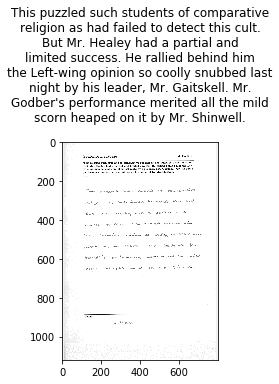

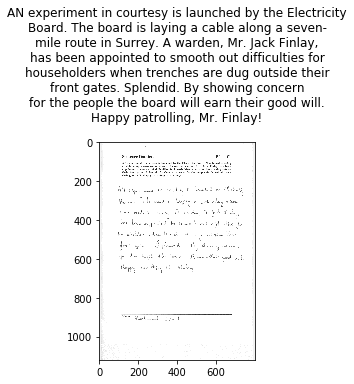

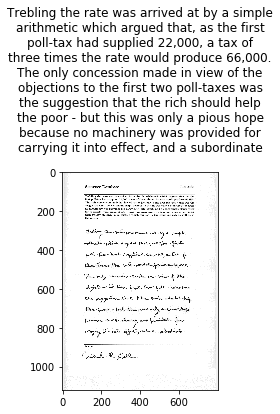

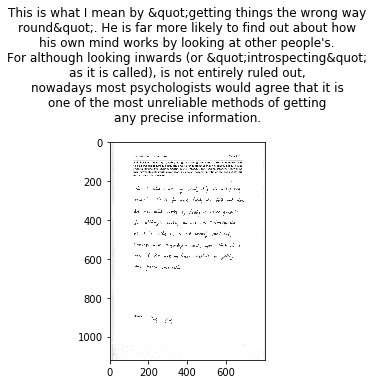

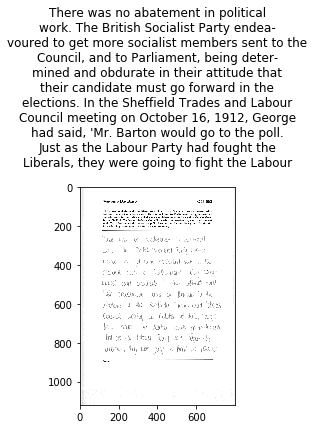

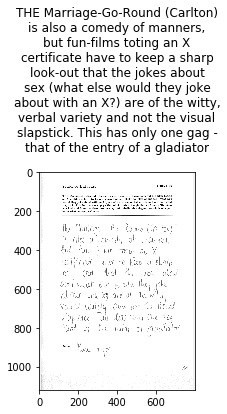

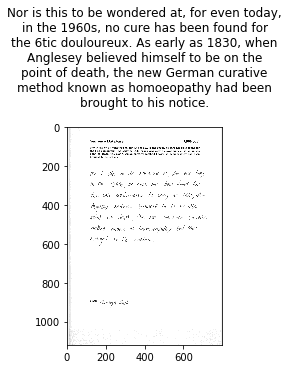

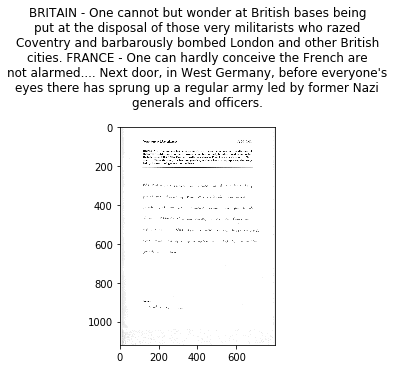

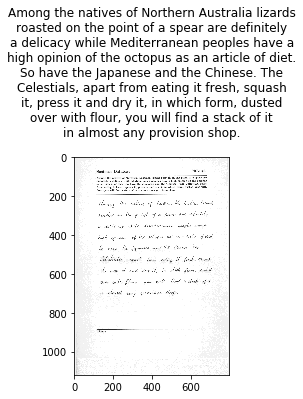

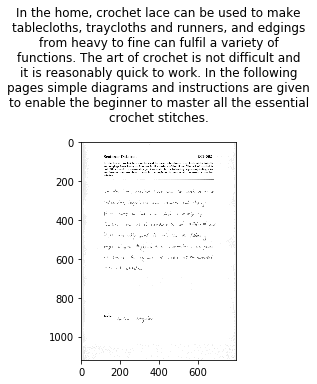

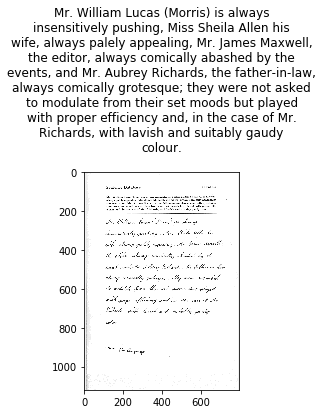

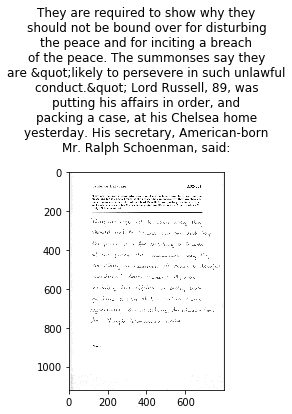

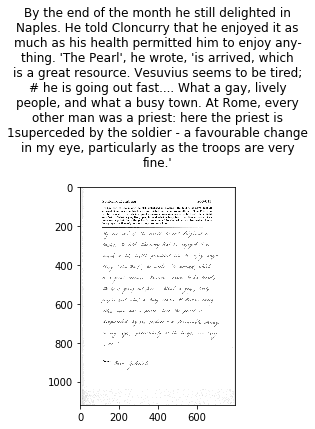

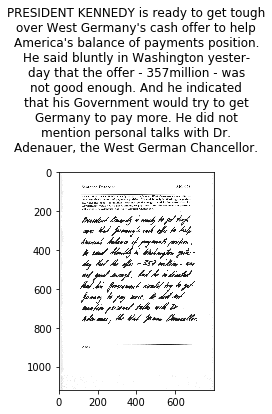

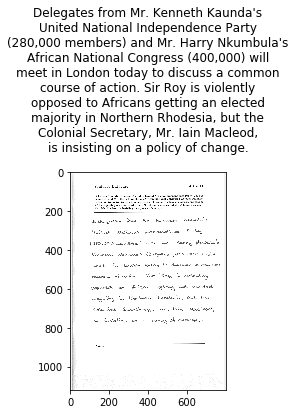

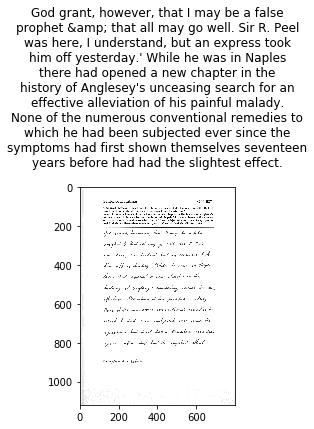

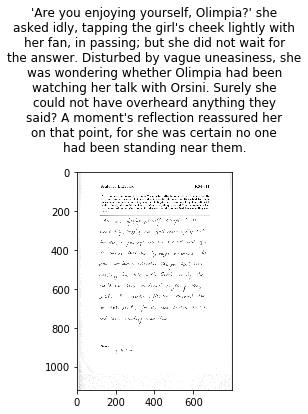

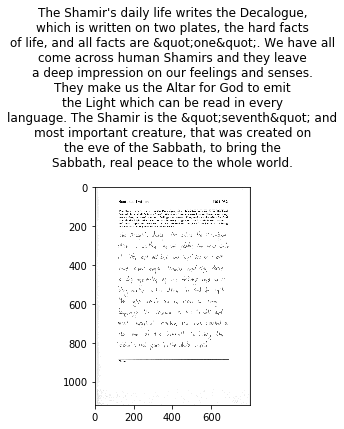

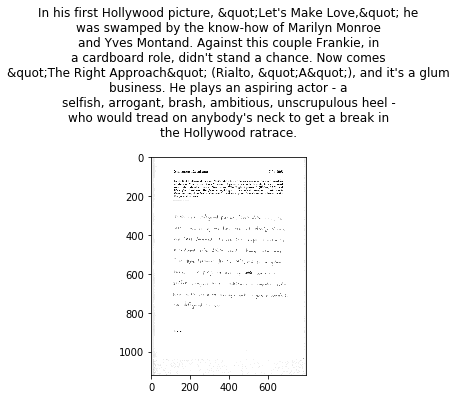

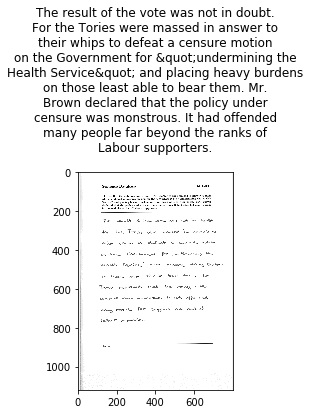

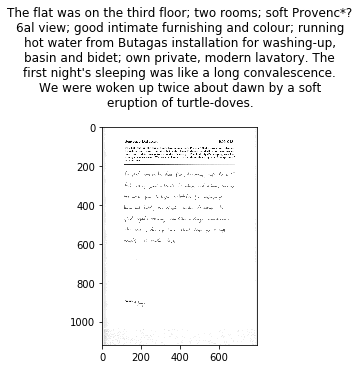

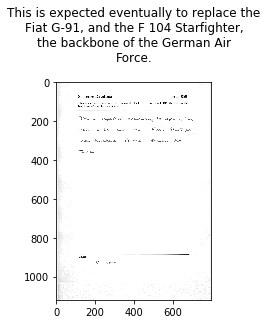

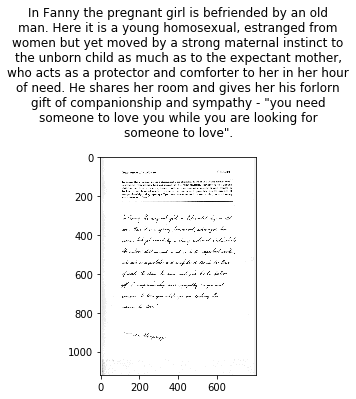

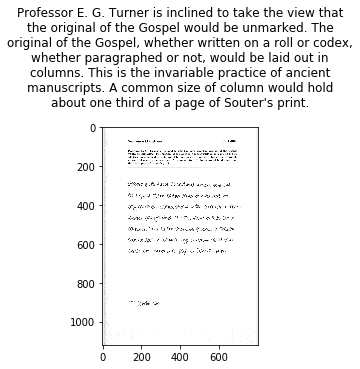

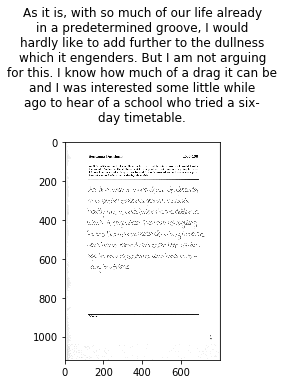

'\nds = IAMDataset("form", output_data="bb", output_parse_method="word")\nplot_image_with_bb(ds)\n\nds = IAMDataset("form", output_data="bb", output_parse_method="line")\nplot_image_with_bb(ds)\n\n\nds = IAMDataset("form", output_data="bb", output_parse_method="form")\nplot_image_with_bb(ds)\n\nds = IAMDataset("form_bb", output_data="bb", output_parse_method="line")\nplot_image_with_bb(ds)\n'

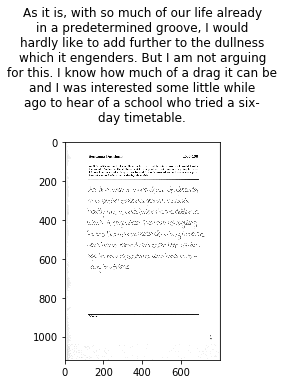

In [0]:

import numpy as np
import random
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display

n_images = 25
"""
def plot_image_with_text(ds):
    fig, ax = plt.subplots(1)
    for i in range(n_images):
        n = int(random.random()*len(ds))
        image_i, text_i = ds[n]
        plt.imshow(image_i, cmap='Greys_r')        
        plt.title(text_i[0])
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)
        
def plot_image_with_bb(ds):
    fig, ax = plt.subplots(1, figsize=(18, 16))

    for i in range(n_images):
        if i > 0:
            for rect in rects: rect.remove()

        n = int(random.random()*len(ds))
        image_i, bb_i = ds[n]
        
        h, w = image_i.shape[0], image_i.shape[1]
        
        plt.imshow(image_i, cmap='Greys_r')
        rects = []
        for j in range(bb_i.shape[0]):
            bb_ij = bb_i[j]
            bb_ij_pixels = [int(bb_ij[0]*w), int(bb_ij[1]*h), int(bb_ij[2]*w), ]
            rect = patches.Rectangle((bb_ij[0]*w, bb_ij[1]*h), bb_ij[2]*w, bb_ij[3]*h, 
                                     fill=False, color="r")
            rects.append(rect)
            ax.add_patch(rect)

        display.display(plt.gcf())
        display.clear_output(wait=True)

        time.sleep(1)
'''
ds = IAMDataset("word", output_data="text")
plot_image_with_text(ds)


ds = IAMDataset("line", output_data="text")
plot_image_with_text(ds)
'''
"""
textarr=[]
ds = IAMDataset("form", output_data="text")
#plot_image_with_text(ds)
fig, ax = plt.subplots(1)
for i in range(n_images):
        image_i, text_i = ds[i]
        plt.imshow(image_i, cmap='Greys_r')        
        plt.title(text_i[0])
        display.display(plt.gcf())
        textarr.append(text_i[0])





'''
ds = IAMDataset("form", output_data="bb", output_parse_method="word")
plot_image_with_bb(ds)

ds = IAMDataset("form", output_data="bb", output_parse_method="line")
plot_image_with_bb(ds)


ds = IAMDataset("form", output_data="bb", output_parse_method="form")
plot_image_with_bb(ds)

ds = IAMDataset("form_bb", output_data="bb", output_parse_method="line")
plot_image_with_bb(ds)
'''


In [22]:
import spacy
import warnings
warnings.filterwarnings("ignore", category=Warning)
nlp = spacy.load('en')
simarr=[]
textarr=["Clustering of data is the process by @ which  similar groups of data can be @ viewed together in a way such that @ * * insights can be extracted @ which can be further used to enhance @ business models and help the company @ make data driven decisions to grow @ / @ / @ sales, and lead to an overall @ growth in the company by cutting @ down unnecessary expenditure @ and focus on funds in more @ useful arenas","The process of clustering of the data @ into similar groups such that they @ can be viewed together is called @ Data Clustering. This helps extract @ insights from the data which can be used @ in business models to make @ data driven decisions, which helps @ the company to grow sales and cut @ down on unnecessary expenditure.","Clustering is the task of grouping values @ into groups that are more similar to each @ other than in other groups In Analysis, @ clustering is part of the Unsupervised @ Analysis,  a type of analysis that @ where you do not have the historical @ data to train the machine predict, @ so you explore patterns","Clustering is the task of grouping values @ into groups that are more similar to each @ other than in other groups In Analysis, @ clustering is part of the Unsupervised @ Analysis,  a type of analysis that @ where you do not have the historical @ data to train the machine predict, @ so you explore patterns","Clustering of data is the process by @ which  similar groups of data can be @ viewed together in a way such that @ * * insights can be extracted @ which can be further used to enhance @ business models and help the company @ make data driven decisions to grow @ / @ / @ sales, and lead to an overall @ growth in the company by cutting @ down unnecessary expenditure @ and focus on funds in more @ useful arenas","Clustering of data is the process by @ which  similar groups of data can be @ viewed together in a way such that @ * * insights can be extracted @ which can be further used to enhance @ business models and help the company @ make data driven decisions to grow @ / @ / @ sales, and lead to an overall @ growth in the company by cutting @ down unnecessary expenditure"]
#textarr=["A * mobile is a wireless handheld device that allows users to make and @ recieve calls and to send text messages among other @ features. The earliest generation of mobile phones @ could only make and receive calls.", "A mobile is a wireless handheld device that allows users to make and @ recieve calls and to send text messages among other @ features. The earliest generation of mobile phone @ could only make amd receive calls.", "A mobile is a wireless handheld device that @ allows users to make and recieve calls and to send * text messages among other @ features. @ The earliest generation of mobile phones could only @ make and receive calls.", "A * mobile is a * wireless * handheld device that allows @ users to make and recieve calls and to send text @ messages among other features. @ The earliest generation of mobile phones could only @ make amd receive calls.", "A mobile phone is a wireless handheld device that allows @ users to make and recieve calls and to send text messages @ among other features. @ The earliest generation of mobile phones could only @ make amd receive calls."]
max=0
maxind=0
for i in range(6):
  tp1=textarr[i]
  #doc1=nlp(tp1.tostring())
  doc1=nlp(tp1)
  sum=0
  for j in range(6):
    tp2=textarr[j]
    #doc2=nlp(tp2.tostring())
    doc2=nlp(tp2)
    sim=doc1.similarity(doc2)
    sum+=sim
    print("similarity of doc ",(i+1)," with doc ",(j+1)," = ",sim*100," %")
  if sum>=max:
    max=sum
    maxind=i
  simarr.append(sum)
  print("total similarity of doc ",(i+1)," with other documents= ",sum*100/6," %")

print(" max= ",max*100/6," index from whom copied= ",maxind+1)



similarity of doc  1  with doc  1  =  100.0  %
similarity of doc  1  with doc  2  =  93.70453323296273  %
similarity of doc  1  with doc  3  =  88.88763385518453  %
similarity of doc  1  with doc  4  =  88.88763385518453  %
similarity of doc  1  with doc  5  =  100.0  %
similarity of doc  1  with doc  6  =  99.52903522565221  %
total similarity of doc  1  with other documents=  95.16813936149735  %
similarity of doc  2  with doc  1  =  93.70453323296273  %
similarity of doc  2  with doc  2  =  100.0  %
similarity of doc  2  with doc  3  =  84.22472273949553  %
similarity of doc  2  with doc  4  =  84.22472273949553  %
similarity of doc  2  with doc  5  =  93.70453323296273  %
similarity of doc  2  with doc  6  =  93.78094940970117  %
total similarity of doc  2  with other documents=  91.60657689243628  %
similarity of doc  3  with doc  1  =  88.88763385518453  %
similarity of doc  3  with doc  2  =  84.22472273949553  %
similarity of doc  3  with doc  3  =  100.0  %
similarity of doc  

In [23]:
import spacy
import warnings
warnings.filterwarnings("ignore", category=Warning)
nlp = spacy.load('en')
simarr=[]
#textarr=["Clustering of data is the process by @ which  similar groups of data can be @ viewed together in a way such that @ * * insights can be extracted @ which can be further used to enhance @ business models and help the company @ make data driven decisions to grow @ / @ / @ sales, and lead to an overall @ growth in the company by cutting @ down unnecessary expenditure @ and focus on funds in more @ useful arenas","The process of clustering of the data @ into similar groups such that they @ can be viewed together is called @ Data Clustering. This helps extract @ insights from the data which can be used @ in business models to make @ data driven decisions, which helps @ the company to grow sales and cut @ down on unnecessary expenditure.","Clustering is the task of grouping values @ into groups that are more similar to each @ other than in other groups In Analysis, @ clustering is part of the Unsupervised @ Analysis,  a type of analysis that @ where you do not have the historical @ data to train the machine predict, @ so you explore patterns","Clustering is the task of grouping values @ into groups that are more similar to each @ other than in other groups In Analysis, @ clustering is part of the Unsupervised @ Analysis,  a type of analysis that @ where you do not have the historical @ data to train the machine predict, @ so you explore patterns","Clustering of data is the process by @ which  similar groups of data can be @ viewed together in a way such that @ * * insights can be extracted @ which can be further used to enhance @ business models and help the company @ make data driven decisions to grow @ / @ / @ sales, and lead to an overall @ growth in the company by cutting @ down unnecessary expenditure @ and focus on funds in more @ useful arenas","Clustering of data is the process by @ which  similar groups of data can be @ viewed together in a way such that @ * * insights can be extracted @ which can be further used to enhance @ business models and help the company @ make data driven decisions to grow @ / @ / @ sales, and lead to an overall @ growth in the company by cutting @ down unnecessary expenditure"]
textarr=["A * mobile is a wireless handheld device that allows users to make and @ recieve calls and to send text messages among other @ features. The earliest generation of mobile phones @ could only make and receive calls.", "A mobile is a wireless handheld device that allows users to make and @ recieve calls and to send text messages among other @ features. The earliest generation of mobile phone @ could only make amd receive calls.", "A mobile is a wireless handheld device that @ allows users to make and recieve calls and to send * text messages among other @ features. @ The earliest generation of mobile phones could only @ make and receive calls.", "A * mobile is a * wireless * handheld device that allows @ users to make and recieve calls and to send text @ messages among other features. @ The earliest generation of mobile phones could only @ make amd receive calls.", "A mobile phone is a wireless handheld device that allows @ users to make and recieve calls and to send text messages @ among other features. @ The earliest generation of mobile phones could only @ make amd receive calls."]
max=0
maxind=0
for i in range(5):
  tp1=textarr[i]
  #doc1=nlp(tp1.tostring())
  doc1=nlp(tp1)
  sum=0
  for j in range(5):
    tp2=textarr[j]
    #doc2=nlp(tp2.tostring())
    doc2=nlp(tp2)
    sim=doc1.similarity(doc2)
    sum+=sim
    print("similarity of doc ",(i+1)," with doc ",(j+1)," = ",sim*100," %")
  if sum>=max:
    max=sum
    maxind=i
  simarr.append(sum)
  print("total similarity of doc ",(i+1)," with other documents= ",sum*100/5," %")

print(" max= ",max*100/5," index from whom copied= ",maxind+1)


similarity of doc  1  with doc  1  =  100.0  %
similarity of doc  1  with doc  2  =  98.56666534338765  %
similarity of doc  1  with doc  3  =  98.66608028974193  %
similarity of doc  1  with doc  4  =  97.34485900520077  %
similarity of doc  1  with doc  5  =  97.56235185161611  %
total similarity of doc  1  with other documents=  98.42799129798928  %
similarity of doc  2  with doc  1  =  98.56666534338765  %
similarity of doc  2  with doc  2  =  100.0  %
similarity of doc  2  with doc  3  =  98.201798562998  %
similarity of doc  2  with doc  4  =  96.4317575488406  %
similarity of doc  2  with doc  5  =  98.36055375028016  %
total similarity of doc  2  with other documents=  98.31215504110126  %
similarity of doc  3  with doc  1  =  98.66608028974193  %
similarity of doc  3  with doc  2  =  98.201798562998  %
similarity of doc  3  with doc  3  =  100.0  %
similarity of doc  3  with doc  4  =  97.98177144562243  %
similarity of doc  3  with doc  5  =  98.35361721966612  %
total simila

In [21]:
!pip3 install scikit-image opencv-python imutils

In [0]:
# 1. Import the necessary packages
from skimage.measure import compare_ssim
import argparse
import imutils
import cv2

# 3. Load the two input images
imageA = cv2.imread("1.png")
imageB = cv2.imread("2.png")

# 4. Convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

# 5. Compute the Structural Similarity Index (SSIM) between the two
#    images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")

# 6. You can print only the score if you want
print("SSIM: {}".format(score))

error: ignored

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# A list with your data slightly edited
l = [100,65.64983205,67.2585066,66.8559351,100,58.65715975,65.64983205,100,73.92217195,74.59217673,65.64983205,63.71848071,67.2585066,73.92217195,100,80.52360821,67.2585066,66.9990075,66.8559351,74.59217673,80.52360821,100,66.8559351,67.09230611,100,65.64983205,67.2585066,66.8559351,100,58.65715975,58.65715975,63.71848071,66.99900759,67.09230611,58.65715975,100]
# Split list
n = 6
data = [l[i:i + n] for i in range(0, len(l), n)]

# A dataframe
df = pd.DataFrame(data)

def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)


CorrMtx(df, dropDuplicates = False)